In [3]:
import sys
import cv
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tippy.segmentations as se
import tippy.basic_operations as bo
import tippy.display_operations as do
from skfuzzy import control as ctrl
from sklearn.metrics import confusion_matrix
from PIL import Image
from skimage import morphology as morph
from scipy import misc
from scipy import ndimage
from time import time
from itertools import compress

In [4]:
# Sørensen–Dice

def dice(ref1, img):
    ref1 = np.asarray(ref1).astype(np.bool)
    img = np.asarray(img).astype(np.bool)
    
    if ref1.shape != img.shape:
        raise ValueError("Shape mismatch: ref and img must have the same shape")
    
    TP = np.logical_and(ref1,img) # TRUE POSITIVE (interseção das imagens)
    
    return (2.0*TP.sum()) / (ref1.sum() + img.sum())

In [5]:
# Jaccard

def jaccard(ref1, img):
    ref1 = np.asarray(ref1).astype(np.bool)
    img = np.asarray(img).astype(np.bool)
    
    if ref1.shape != img.shape:
        raise ValueError("Shape mismatch: ref and img must have the same shape")
        
    TP = np.logical_and(ref1,img) # TRUE POSITIVE (interseção das imagens)
    return (TP.sum())*1.0 / (ref1.sum() + img.sum() - TP.sum())

In [6]:
# confusion_matrix

def conf_matrix(ref1, img):
    ref1 = np.asarray(ref1).astype(np.bool)
    img = np.asarray(img).astype(np.bool)
    
    cm = confusion_matrix(ref1, img)    
    total = sum(sum(cm))
    
    TP = cm[1,1]
    TN = cm[0,0]
    FN = cm[1,0]
    FP = cm[0,1]
       
    accuracy = (TP*1.0 + TN) / total
    sensitivity = TP*1.0 / (TP+FN)
    specificity = TN*1.0 / (TN+FP)
    return(accuracy, sensitivity, specificity)

In [7]:
def calc_estatistica(ref1, img):
    dice1 = dice(ref1, img)
    jacc1 = jaccard(ref1, img)
    conf1 = conf_matrix(ref1.flatten(), img.flatten())
    return([dice1, jacc1, conf1[0], conf1[1], conf1[2]])

In [8]:
def junta_imgs(ref1, img1, img2):
    start = time()
    
    ref1 = np.asarray(ref1).astype(np.bool)
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)
    
    img_final = np.logical_or(img1, img2)
    
    lista = calc_estatistica(ref1, img_final)
    
    tempo_final = time() - start
    
    return(img_final, lista[0], lista[1], lista[2], lista[3], lista[4], tempo_final)

In [9]:
def fuzzySystem_OP(pixel, vm):

    # pixelIN variables
    x_pixelIN = np.linspace(0, 1, 100)
    x_pixelOUT  = np.linspace(0, 1, 100)

    # Generate fuzzy membership functions
    pixelIN_sm = fuzz.trapmf(x_pixelIN, [0, 0, 0.15*vm, 0.6*vm])
    pixelIN_md = fuzz.trimf(x_pixelIN, [0.5*vm, vm, 1.4*vm])
    pixelIN_la = fuzz.trapmf(x_pixelIN, [1.3*vm, 1.6*vm, 1, 1])
    
    pixelOUT_sm = fuzz.trapmf(x_pixelOUT, [0, 0, 0.05, 0.1])
    pixelOUT_md = fuzz.trimf(x_pixelOUT, [0.45, 0.5, 0.55])
    pixelOUT_la = fuzz.trapmf(x_pixelOUT, [0.9, 0.95, 1, 1])
    
    # Activation of fuzzy membership functions at vm using fuzz.interp_membership 
    pixelIN_level_sm = fuzz.interp_membership(x_pixelIN, pixelIN_sm, pixel)
    pixelIN_level_md = fuzz.interp_membership(x_pixelIN, pixelIN_md, pixel)
    pixelIN_level_la = fuzz.interp_membership(x_pixelIN, pixelIN_la, pixel)

    # Rules for OP
    rule1 = np.fmin(pixelIN_level_sm, pixelOUT_sm) # edge
    rule2 = np.fmin(pixelIN_level_md, pixelOUT_la) # liver
    rule3 = np.fmin(pixelIN_level_la, pixelOUT_md) # vessel
    
    # Aggregating the output membership functions
    aggregated = np.fmax(rule1, np.fmax(rule2, rule3))
    
    # Calculating the result
    output = fuzz.defuzz(x_pixelOUT, aggregated, 'centroid')
    output_activation = fuzz.interp_membership(x_pixelOUT, aggregated, output) # for plot
    
    return(output)

def fuzzySystem_IP(pixel, vm):

    # pixelIN variables
    x_pixelIN = np.linspace(0, 1, 100)
    x_pixelOUT  = np.linspace(0, 1, 100)

    # Generate fuzzy membership functions
    pixelIN_sm = fuzz.trapmf(x_pixelIN, [0, 0, 0.15*vm, 0.9*vm])
    pixelIN_md = fuzz.trimf(x_pixelIN, [0.87*vm, vm, 1.3*vm])
    pixelIN_la = fuzz.trapmf(x_pixelIN, [1.2*vm, 1.6*vm, 1, 1])

    pixelOUT_sm = fuzz.trapmf(x_pixelOUT, [0, 0, 0.05, 0.1])
    pixelOUT_md = fuzz.trimf(x_pixelOUT, [0.45, 0.5, 0.55])
    pixelOUT_la = fuzz.trapmf(x_pixelOUT, [0.9, 0.95, 1, 1])

    # Activation of fuzzy membership functions at vm using fuzz.interp_membership 
    pixelIN_level_sm = fuzz.interp_membership(x_pixelIN, pixelIN_sm, pixel)
    pixelIN_level_md = fuzz.interp_membership(x_pixelIN, pixelIN_md, pixel)
    pixelIN_level_la = fuzz.interp_membership(x_pixelIN, pixelIN_la, pixel)
    
    # Rules for IP
    rule1 = np.fmin(pixelIN_level_sm, pixelOUT_md) # vessel
    rule2 = np.fmin(pixelIN_level_md, pixelOUT_la) # liver
    rule3 = np.fmin(pixelIN_level_la, pixelOUT_sm) # edge
    
    # Aggregating the output membership functions
    aggregated = np.fmax(rule1, np.fmax(rule2, rule3))
    
    # Calculating the result
    output = fuzz.defuzz(x_pixelOUT, aggregated, 'centroid')
    output_activation = fuzz.interp_membership(x_pixelOUT, aggregated, output) # for plot
    
    return(output)

In [10]:
def fuzzy_seg(imgOP_orig, imgIP_orig, ref, vmed_op, vmed_ip, seed, indices_list):

    ###############################################################################
    '''
    pixelOP = np.genfromtxt("dataset01\s01-27-op-231-94-102.txt")
    pixelIP = np.genfromtxt("dataset01\s01-27-ip-432.txt")
    ref = np.genfromtxt("dataset01\s01-25-ref.txt")

    vmed_op = 231.0
    vmed_ip = 432.0
    seed = (94,102)
    '''
    ###############################################################################

    vmed_op = vmed_op/4095.0
    vmed_ip = vmed_ip/4095.0
    
    imgOP = np.zeros(imgOP_orig.shape)
    imgIP = np.zeros(imgIP_orig.shape)

    pixelOP = imgOP_orig*(1.0/4095.0)
    pixelIP = imgIP_orig*(1.0/4095.0)
    
    for i in (indices_list):
        imgOP[i] = fuzzySystem_OP(pixelOP[i], vmed_op)

    for i in (indices_list):
        imgIP[i] = fuzzySystem_IP(pixelIP[i], vmed_ip)
    
    plt.imshow(imgOP)
    plt.show()
    
    plt.imshow(imgIP)
    plt.show()
    
    ###############################################################################
    
    maskOP = imgOP > 0.6
    maskIP = imgIP > 0.6
       
    maskAND = np.logical_and(maskOP, maskIP)
    maskerosion = morph.binary_erosion(maskAND)
    maskopen = morph.binary_opening(maskerosion)
    
    plt.imshow(maskopen)
    plt.show()
    
    misc.imsave('maskfinal.bmp', maskopen)

    ###############################################################################

    user_input = 0

    img_name = "maskfinal.bmp"
    threshold = 20
    img = cv.LoadImage(img_name, cv.CV_LOAD_IMAGE_GRAYSCALE)
    out_img = se.simple_region_growing(img, seed, threshold)
    out_img = np.asarray(out_img[:,:])
   
    return out_img

In [11]:
def simple_region_growing(img, seed, threshold=1):
    """
    A (very) simple implementation of region growing.
    Extracts a region of the input image depending on a start position and a stop condition.
    The input should be a single channel 8 bits image and the seed a pixel position (x, y).
    The threshold corresponds to the difference between outside pixel intensity and mean intensity of region.
    In case no new pixel is found, the growing stops.
    Outputs a single channel 8 bits binary (0 or 255) image. Extracted region is highlighted in white.
    """

    try:
        dims = cv.GetSize(img)
    except TypeError:
        raise TypeError("(%s) img : IplImage expected!" % (sys._getframe().f_code.co_name))

    # img test
    if not(img.depth == cv.IPL_DEPTH_8U):
        raise TypeError("(%s) 8U image expected!" % (sys._getframe().f_code.co_name))
    elif not(img.nChannels is 1):
        raise TypeError("(%s) 1C image expected!" % (sys._getframe().f_code.co_name))
    # threshold tests
    if (not isinstance(threshold, int)) :
        raise TypeError("(%s) Int expected!" % (sys._getframe().f_code.co_name))
    elif threshold < 0:
        raise ValueError("(%s) Positive value expected!" % (sys._getframe().f_code.co_name))
    # seed tests
    if not((isinstance(seed, tuple)) and (len(seed) is 2) ) :
        raise TypeError("(%s) (x, y) variable expected!" % (sys._getframe().f_code.co_name))

    if (seed[0] or seed[1] ) < 0 :
        raise ValueError("(%s) Seed should have positive values!" % (sys._getframe().f_code.co_name))
    elif ((seed[0] > dims[0]) or (seed[1] > dims[1])):
        raise ValueError("(%s) Seed values greater than img size!" % (sys._getframe().f_code.co_name))

    reg = cv.CreateImage( dims, cv.IPL_DEPTH_8U, 1)
    cv.Zero(reg)

    #parameters
    mean_reg = float(img[seed[1], seed[0]])
    size = 1
    pix_area = dims[0]*dims[1]

    contour = [] # will be [ [[x1, y1], val1],..., [[xn, yn], valn] ]
    contour_val = []
    dist = 0
    # TODO: may be enhanced later with 8th connectivity
    orient = [(1, 0), (0, 1), (-1, 0), (0, -1)] # 4 connectivity
    cur_pix = [seed[0], seed[1]]

    #Spreading
    while(dist<threshold and size<pix_area):
    #adding pixels
        for j in range(4):
            #select new candidate
            temp_pix = [cur_pix[0] +orient[j][0], cur_pix[1] +orient[j][1]]

            #check if it belongs to the image
            is_in_img = dims[0]>temp_pix[0]>0 and dims[1]>temp_pix[1]>0 #returns boolean
            #candidate is taken if not already selected before
            if (is_in_img and (reg[temp_pix[1], temp_pix[0]]==0)):
                contour.append(temp_pix)
                contour_val.append(img[temp_pix[1], temp_pix[0]] )
                reg[temp_pix[1], temp_pix[0]] = 150
        #add the nearest pixel of the contour in it
        dist = abs(int(np.mean(contour_val)) - mean_reg)

        dist_list = [abs(i - mean_reg) for i in contour_val ]
        dist = min(dist_list)    #get min distance
        index = dist_list.index(min(dist_list)) #mean distance index
        size += 1 # updating region size
        reg[cur_pix[1], cur_pix[0]] = 255

        #updating mean MUST BE FLOAT
        mean_reg = (mean_reg*size + float(contour_val[index]))/(size+1)
        #updating seed
        cur_pix = contour[index]

        #removing pixel from neigborhood
        del contour[index]
        del contour_val[index]

    return reg

In [12]:
def true_Indices(imgCV, seed, threshold=15):
    pre_grow_cv = se.simple_region_growing(imgCV, seed, threshold)
    pre_grow = np.asarray(pre_grow_cv[:,:]).astype(np.bool)
    #plt.imshow(pre_grow, cmap='gray')
    #plt.show()
           
    pre_grow_dim = pre_grow.shape
    pre_grow_flat = pre_grow.flatten()
    
    true_indices_flat = list(compress(xrange(len(pre_grow_flat)), pre_grow_flat))
    true_indices = np.unravel_index(true_indices_flat,pre_grow_dim)
    return zip(true_indices[0],true_indices[1])

In [13]:
def start_segm(op, ip, ref):
    start = time()
    
    user_input = 0
        
    #get seeds from user
    misc.imsave('inputOP.bmp', op) #saves OP image as bitmap to be used by CV
    img_name = "inputOP.bmp"
    img = cv.LoadImage(img_name, cv.CV_LOAD_IMAGE_GRAYSCALE)
    inputseeds = bo.mouse_point(img, mode="M") # waits for user click to get seed, returns tuple inside a list
    print inputseeds    
    
    #get max, min and mean grey values from seeds
    grey_valueOP = []
    grey_valueIP = []
    for tuples in inputseeds:
        grey_valueOP = np.append(grey_valueOP, op[tuples[1],tuples[0]])
        grey_valueIP = np.append(grey_valueIP, ip[tuples[1],tuples[0]])
    
    ################################################################################################################
    
    #para fuzzy com vm = max
    grey_max_OP = np.max(grey_valueOP)
    grey_max_IP = np.max(grey_valueIP)
    seed_max = inputseeds[np.argmax(grey_valueOP)] #get the seed  (y,x) corresponding to the max grey value
    print seed_max
    true_idx_max = true_Indices(img, seed_max)
    result_max = fuzzy_seg(inputOP, inputIP, inputref, grey_max_OP, grey_max_IP, seed_max, true_idx_max)
     
    #para fuzzy com vm = min
    grey_min_OP = np.min(grey_valueOP)
    grey_min_IP = np.min(grey_valueIP)
    seed_min = inputseeds[np.argmin(grey_valueOP)] #get the seed  (y,x) corresponding to the minimum grey value
    print seed_min
    true_idx_min = true_Indices(img, seed_min)
    result_min = fuzzy_seg(inputOP, inputIP, inputref, grey_min_OP, grey_min_IP, seed_min, true_idx_min)
    
        
    #para fuzzy com vm = mean
    grey_mean_OP = np.mean(grey_valueOP)
    grey_mean_IP = np.mean(grey_valueIP)
    seed_mean = inputseeds[min(range(len(grey_valueOP)), key=lambda i: abs(grey_valueOP[i]-grey_mean_OP))] #get the seed  (y,x)
    print seed_mean
    true_idx_mean = true_Indices(img, seed_mean)
    result_mean = fuzzy_seg(inputOP, inputIP, inputref, grey_mean_OP, grey_mean_IP, seed_mean, true_idx_mean)
    
    ################################################################################################################
   
    combined_result = np.logical_or(np.logical_or(result_min,result_mean),result_max)
   
    ################################################################################################################
    
    # plot
    f, axarr = plt.subplots(2,2,figsize=(10,10))
    
    axarr[0,0].imshow(op, cmap='gray')
    axarr[0,0].set_title('OP')
    
    axarr[0,1].imshow(ip, cmap='gray')
    axarr[0,1].set_title('IP')
    
    axarr[1,0].imshow(ref, cmap='gray')
    axarr[1,0].set_title('Reference')
    
    axarr[1,1].imshow(combined_result, cmap='gray')
    axarr[1,1].set_title('Result')
    
    plt.show()
    
    ''' 
    plt.imshow(ref, cmap='gray')
    plt.title('ref')
    plt.show()

    plt.imshow(maskOP, cmap='gray')
    plt.title('maskOP')
    plt.show()

    plt.imshow(maskIP, cmap='gray')
    plt.title('maskIP')
    plt.show()

    plt.imshow(maskAND, cmap='gray')
    plt.title('maskAND')
    plt.show()

    plt.imshow(maskopen, cmap='gray')
    plt.title('maskopen')
    plt.show()

    plt.imshow(out_img, cmap='gray')
    plt.title('result')
    plt.show()'''
    
    lista = calc_estatistica(ref, combined_result)
    tempo_final = time() - start
    
    del(inputseeds)
    del(seed_max)
    del(seed_min)
    del(seed_mean)
    
    return(combined_result, lista[0], lista[1], lista[2], lista[3], lista[4], tempo_final)

## COMEÇANDO AQUI S01

In [14]:
listaDICE_S01_03 = []
listaJACC_S01_03 = []
listaACCU_S01_03 = []
listaSENS_S01_03 = []
listaSPEC_S01_03 = []
listaTEMPO_S01_03 = []

[(46, 110), (56, 101), (60, 95), (73, 90), (80, 82), (63, 86), (55, 89), (44, 104)]
(80, 82)


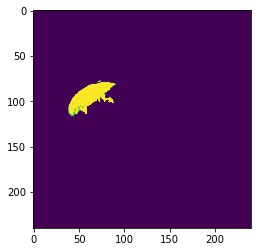

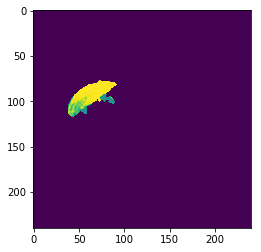

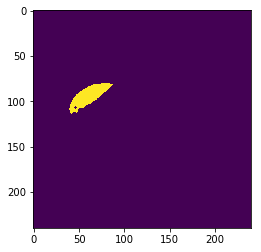

(46, 110)


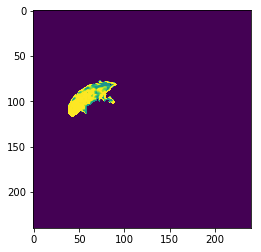

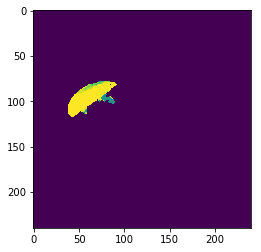

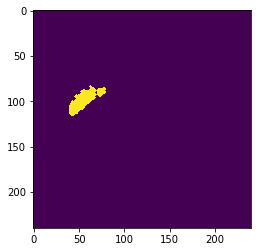

(55, 89)


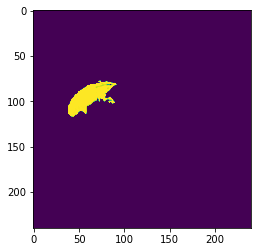

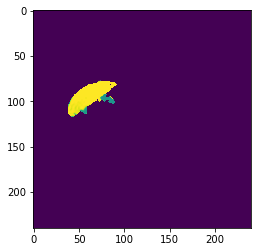

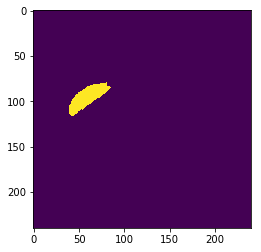

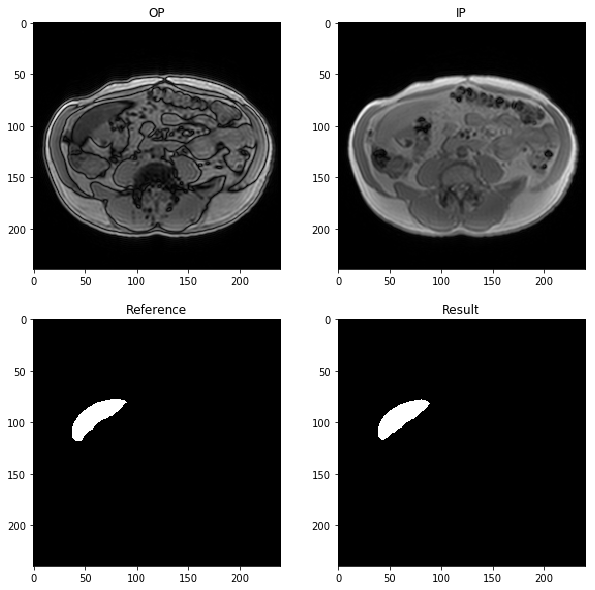

10
10
10
10
10
10


In [22]:
# S01-03
# vmed_op = 230.0
# vmed_ip = 433.0
# seed = (91,102)

inputOP = np.genfromtxt("dataset01\s01-03-op-218-62-95.txt")
inputIP = np.genfromtxt("dataset01\s01-03-ip-474.txt")
inputref = np.genfromtxt("dataset01\s01-03-ref.txt")

result_s01_03_10, dice_s01_03_10, jacc_s01_03_10, accu_s01_03_10, sens_s01_03_10, spec_s01_03_10, tempo_s01_03_10 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_03_10.bmp', result_s01_03_10)

listaDICE_S01_03.append(dice_s01_03_10)
listaJACC_S01_03.append(jacc_s01_03_10)
listaACCU_S01_03.append(accu_s01_03_10)
listaSENS_S01_03.append(sens_s01_03_10)
listaSPEC_S01_03.append(spec_s01_03_10)
listaTEMPO_S01_03.append(tempo_s01_03_10)

print(len(listaDICE_S01_03))
print(len(listaJACC_S01_03))
print(len(listaACCU_S01_03))
print(len(listaSENS_S01_03))
print(len(listaSPEC_S01_03))
print(len(listaTEMPO_S01_03))

del(inputOP)
del(inputIP)
del(inputref)

In [24]:
#print(listaDICE_S01_03)
#print(listaJACC_S01_03)
#print(listaACCU_S01_03)
#print(listaSENS_S01_03)
#print(listaSPEC_S01_03)
#print(listaTEMPO_S01_03)

In [25]:
listaDICE_S01_05 = []
listaJACC_S01_05 = []
listaACCU_S01_05 = []
listaSENS_S01_05 = []
listaSPEC_S01_05 = []
listaTEMPO_S01_05 = []

[(41, 121), (49, 115), (55, 105), (65, 100), (77, 89), (90, 81), (73, 82), (56, 91), (42, 105), (41, 117)]
(90, 81)


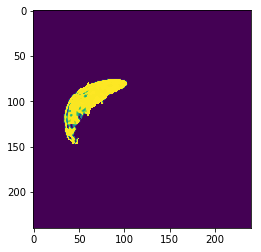

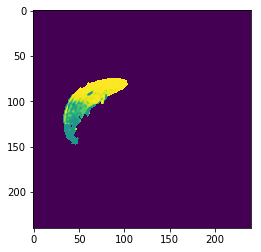

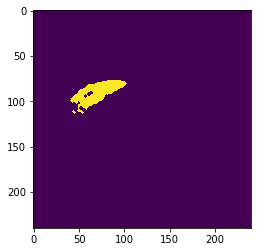

(56, 91)


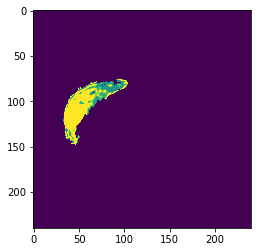

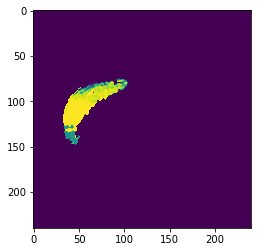

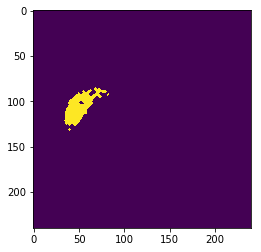

(42, 105)


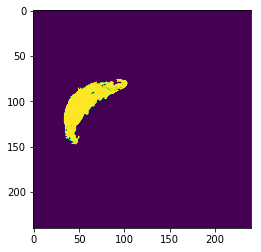

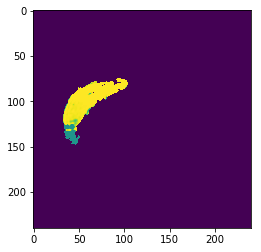

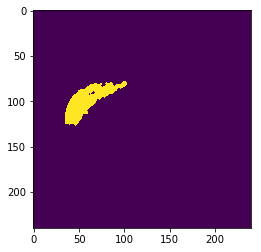

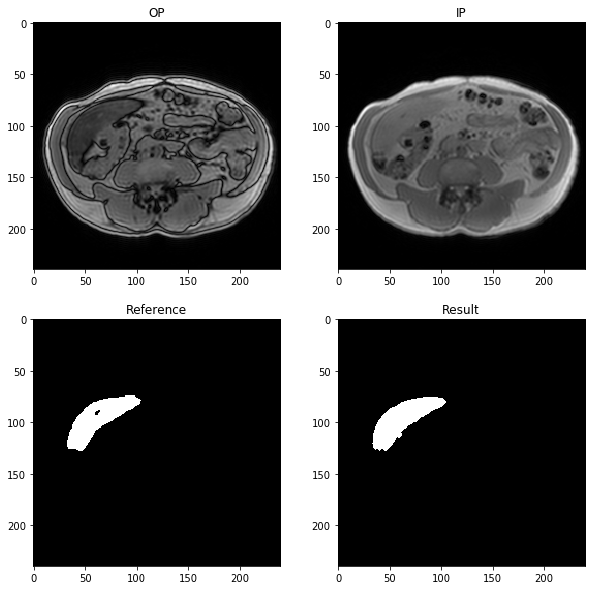

10
10
10
10
10
10


In [39]:
# S01-05
# vmed_op = 249.0
# vmed_ip = 446.0
# seed = (60,102)

inputOP = np.genfromtxt("dataset01\s01-05-op-249-60-102.txt")
inputIP = np.genfromtxt("dataset01\s01-05-ip-446.txt")
inputref = np.genfromtxt("dataset01\s01-05-ref.txt")

result_s01_05_10, dice_s01_05_10, jacc_s01_05_10, accu_s01_05_10, sens_s01_05_10, spec_s01_05_10, tempo_s01_05_10 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_05_10.bmp', result_s01_05_10)

listaDICE_S01_05.append(dice_s01_05_10)
listaJACC_S01_05.append(jacc_s01_05_10)
listaACCU_S01_05.append(accu_s01_05_10)
listaSENS_S01_05.append(sens_s01_05_10)
listaSPEC_S01_05.append(spec_s01_05_10)
listaTEMPO_S01_05.append(tempo_s01_05_10)

print(len(listaDICE_S01_05))
print(len(listaJACC_S01_05))
print(len(listaACCU_S01_05))
print(len(listaSENS_S01_05))
print(len(listaSPEC_S01_05))
print(len(listaTEMPO_S01_05))

del(inputOP)
del(inputIP)
del(inputref)

In [71]:
listaDICE_S01_07 = []
listaJACC_S01_07 = []
listaACCU_S01_07 = []
listaSENS_S01_07 = []
listaSPEC_S01_07 = []
listaTEMPO_S01_07 = []

[(44, 133), (52, 123), (41, 112), (60, 104), (56, 93), (83, 92), (89, 77), (108, 80)]
(89, 77)


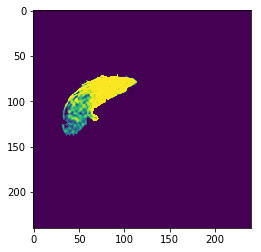

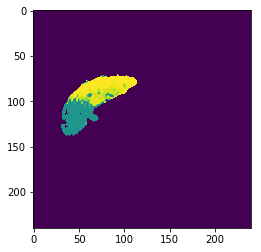

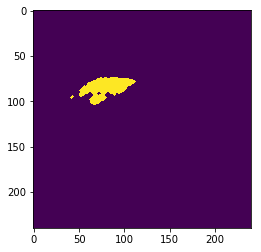

(52, 123)


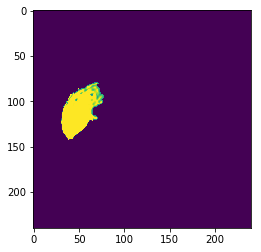

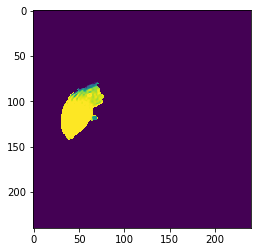

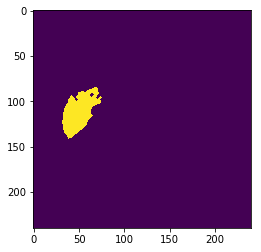

(56, 93)


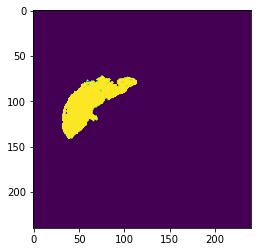

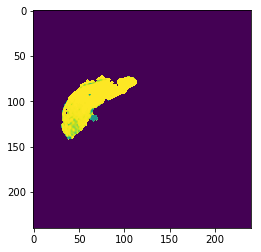

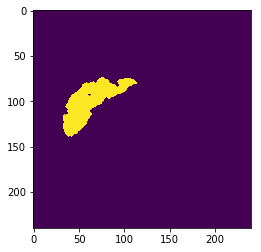

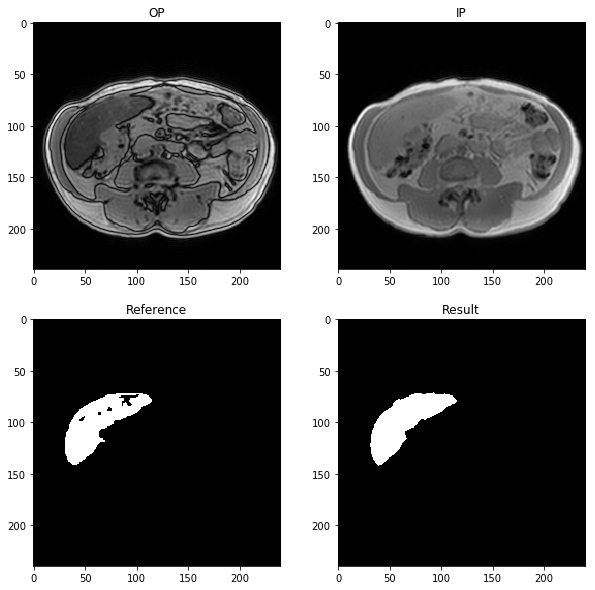

10
10
10
10
10
10


In [83]:
# S01-07

inputOP = np.genfromtxt("dataset01\s01-07-op-233.txt")
inputIP = np.genfromtxt("dataset01\s01-07-ip-460.txt")
inputref = np.genfromtxt("dataset01\s01-07-ref.txt")

result_s01_07_10, dice_s01_07_10, jacc_s01_07_10, accu_s01_07_10, sens_s01_07_10, spec_s01_07_10, tempo_s01_07_10 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_07_10.bmp', result_s01_07_10)

listaDICE_S01_07.append(dice_s01_07_10)
listaJACC_S01_07.append(jacc_s01_07_10)
listaACCU_S01_07.append(accu_s01_07_10)
listaSENS_S01_07.append(sens_s01_07_10)
listaSPEC_S01_07.append(spec_s01_07_10)
listaTEMPO_S01_07.append(tempo_s01_07_10)

print(len(listaDICE_S01_07))
print(len(listaJACC_S01_07))
print(len(listaACCU_S01_07))
print(len(listaSENS_S01_07))
print(len(listaSPEC_S01_07))
print(len(listaTEMPO_S01_07))

del(inputOP)
del(inputIP)
del(inputref)

In [84]:
listaDICE_S01_09 = []
listaJACC_S01_09 = []
listaACCU_S01_09 = []
listaSENS_S01_09 = []
listaSPEC_S01_09 = []
listaTEMPO_S01_09 = []

[(44, 135), (56, 122), (38, 121), (46, 106), (58, 105), (64, 88), (86, 88), (83, 82), (97, 79), (110, 78), (103, 86)]
(83, 82)


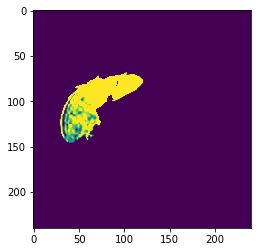

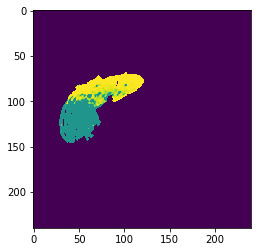

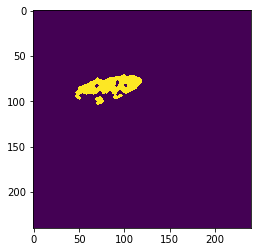

(38, 121)


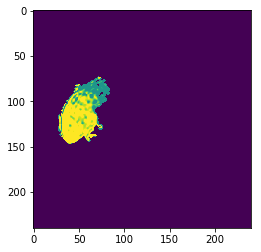

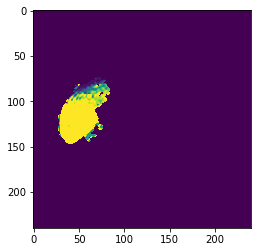

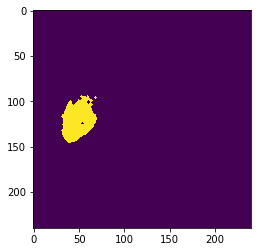

(64, 88)


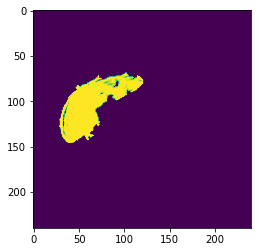

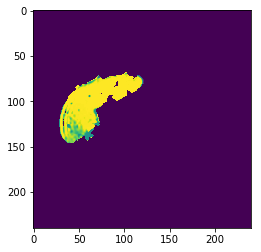

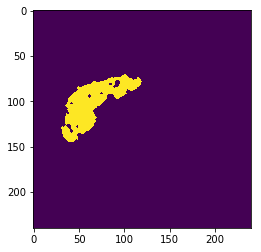

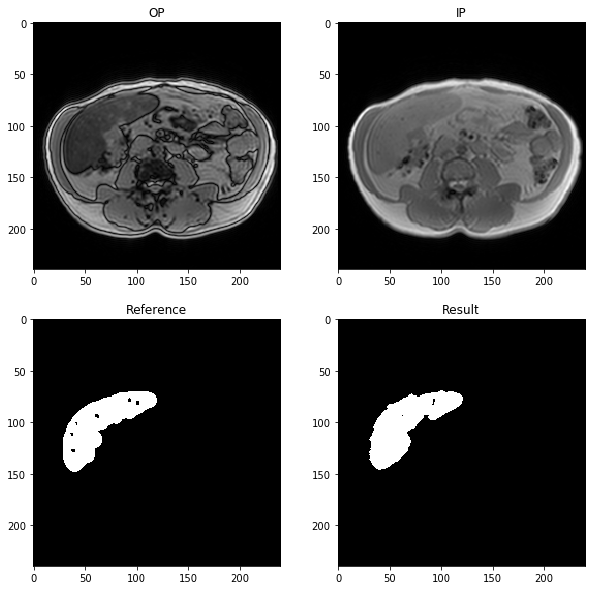

10
10
10
10
10
10


In [94]:
# S01-09

inputOP = np.genfromtxt("dataset01\s01-09-op-229-63-104.txt")
inputIP = np.genfromtxt("dataset01\s01-09-ip-448.txt")
inputref = np.genfromtxt("dataset01\s01-09-ref.txt")

result_s01_09_10, dice_s01_09_10, jacc_s01_09_10, accu_s01_09_10, sens_s01_09_10, spec_s01_09_10, tempo_s01_09_10 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_09_10.bmp', result_s01_09_10)

listaDICE_S01_09.append(dice_s01_09_10)
listaJACC_S01_09.append(jacc_s01_09_10)
listaACCU_S01_09.append(accu_s01_09_10)
listaSENS_S01_09.append(sens_s01_09_10)
listaSPEC_S01_09.append(spec_s01_09_10)
listaTEMPO_S01_09.append(tempo_s01_09_10)

print(len(listaDICE_S01_09))
print(len(listaJACC_S01_09))
print(len(listaACCU_S01_09))
print(len(listaSENS_S01_09))
print(len(listaSPEC_S01_09))
print(len(listaTEMPO_S01_09))

del(inputOP)
del(inputIP)
del(inputref)

In [107]:
listaDICE_S01_11 = []
listaJACC_S01_11 = []
listaACCU_S01_11 = []
listaSENS_S01_11 = []
listaSPEC_S01_11 = []
listaTEMPO_S01_11 = []

[(43, 149), (52, 139), (65, 133), (67, 122), (56, 116), (46, 118), (45, 103), (59, 89), (73, 82), (87, 77), (103, 74), (113, 75), (115, 81), (109, 88)]
(103, 74)


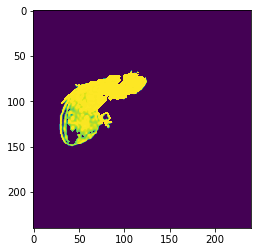

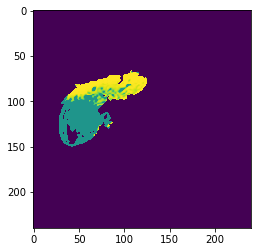

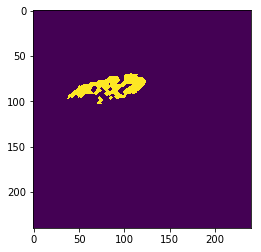

(65, 133)


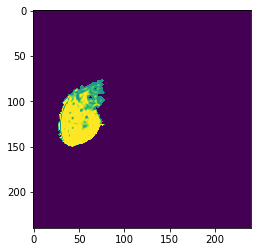

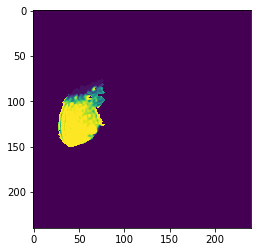

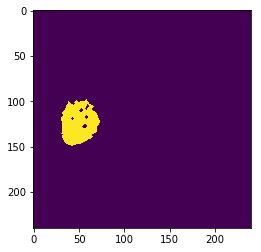

(73, 82)


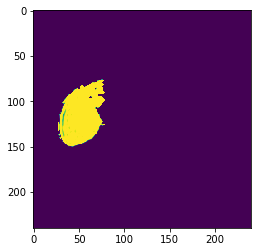

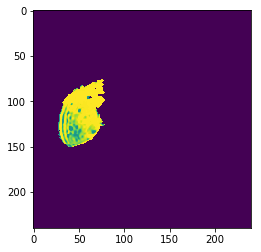

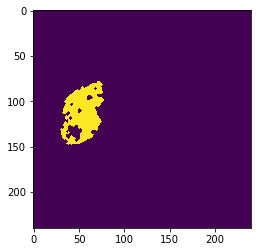

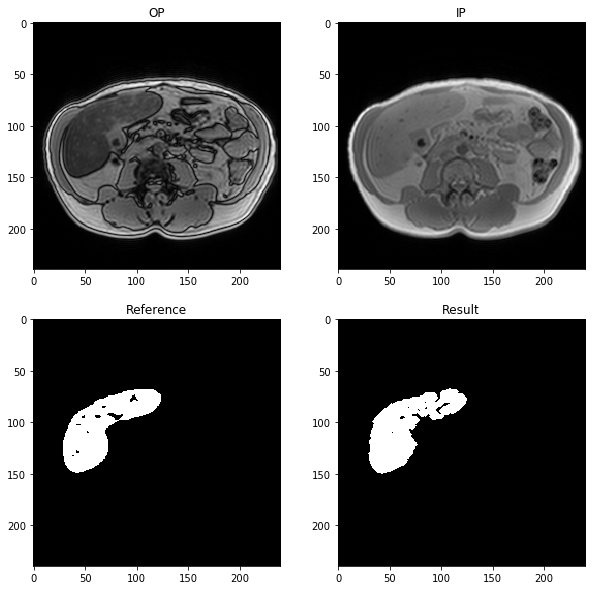

10
10
10
10
10
10


In [117]:
# S01-11

inputOP = np.genfromtxt("dataset01\s01-11-op-233.txt")
inputIP = np.genfromtxt("dataset01\s01-11-ip-449.txt")
inputref = np.genfromtxt("dataset01\s01-11-ref.txt")

result_s01_11_10, dice_s01_11_10, jacc_s01_11_10, accu_s01_11_10, sens_s01_11_10, spec_s01_11_10, tempo_s01_11_10 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_11_10.bmp', result_s01_11_10)

listaDICE_S01_11.append(dice_s01_11_10)
listaJACC_S01_11.append(jacc_s01_11_10)
listaACCU_S01_11.append(accu_s01_11_10)
listaSENS_S01_11.append(sens_s01_11_10)
listaSPEC_S01_11.append(spec_s01_11_10)
listaTEMPO_S01_11.append(tempo_s01_11_10)

print(len(listaDICE_S01_11))
print(len(listaJACC_S01_11))
print(len(listaACCU_S01_11))
print(len(listaSENS_S01_11))
print(len(listaSPEC_S01_11))
print(len(listaTEMPO_S01_11))

del(inputOP)
del(inputIP)
del(inputref)

In [105]:
del(listaDICE_S01_11)
del(listaJACC_S01_11)
del(listaACCU_S01_11)
del(listaSENS_S01_11)
del(listaSPEC_S01_11)
del(listaTEMPO_S01_11)

In [122]:
listaDICE_S01_13 = []
listaJACC_S01_13 = []
listaACCU_S01_13 = []
listaSENS_S01_13 = []
listaSPEC_S01_13 = []
listaTEMPO_S01_13 = []

[(44, 144), (67, 129), (37, 127), (54, 128), (57, 99), (73, 81), (89, 75), (107, 73), (121, 73), (109, 90)]
(107, 73)


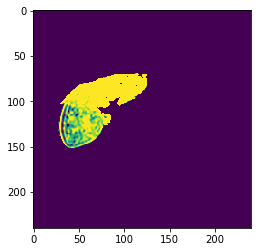

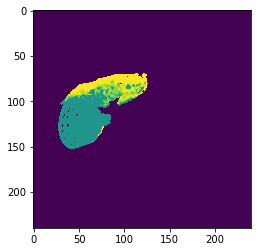

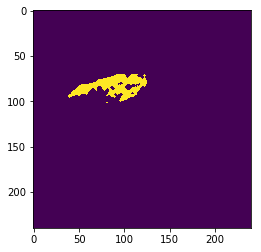

(37, 127)


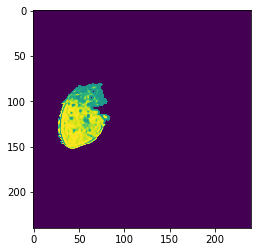

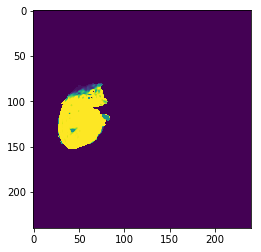

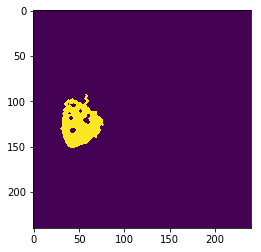

(73, 81)


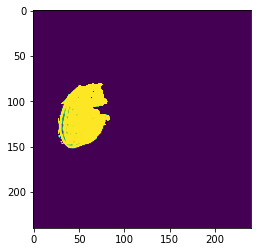

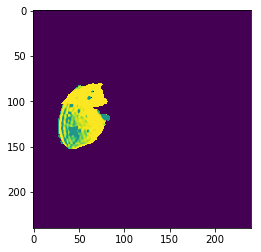

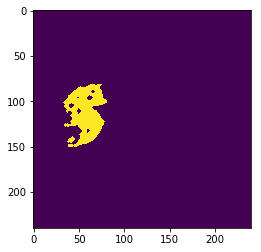

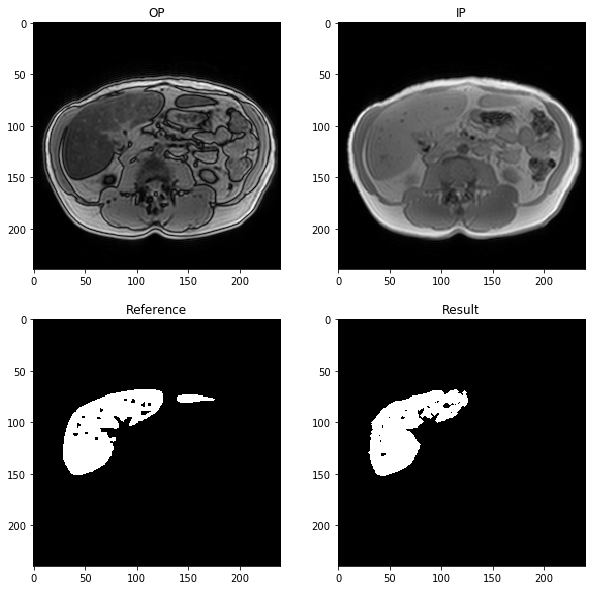

In [146]:
# S01-13_pedaço_MAIOR

inputOP = np.genfromtxt("dataset01\s01-13-op-231.txt")
inputIP = np.genfromtxt("dataset01\s01-13-ip-447.txt")
inputref = np.genfromtxt("dataset01\s01-13-ref.txt")

result_s01_13, dice_s01_13, jacc_s01_13, accu_s01_13, sens_s01_13, spec_s01_13, tempo_s01_13 = start_segm(inputOP, inputIP, inputref)

[(148, 78), (164, 76)]
(164, 76)


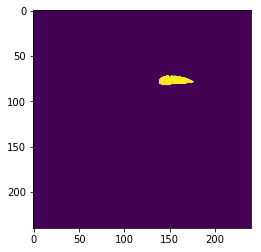

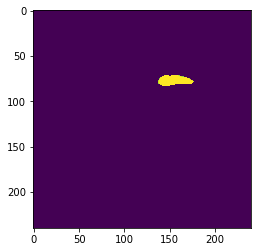

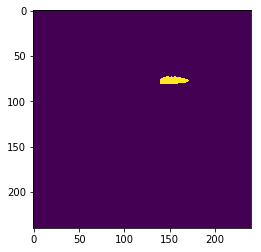

(148, 78)


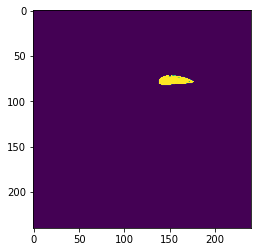

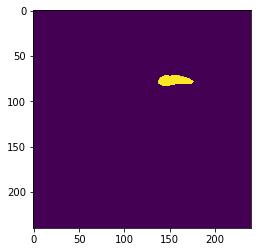

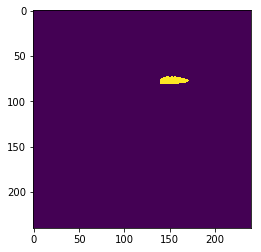

(148, 78)


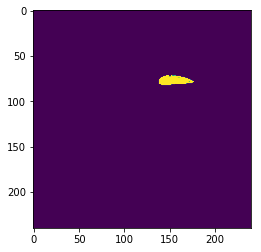

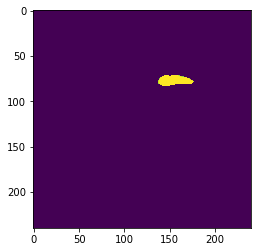

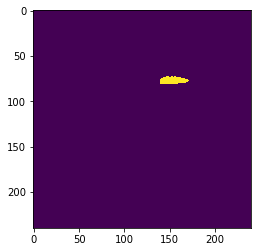

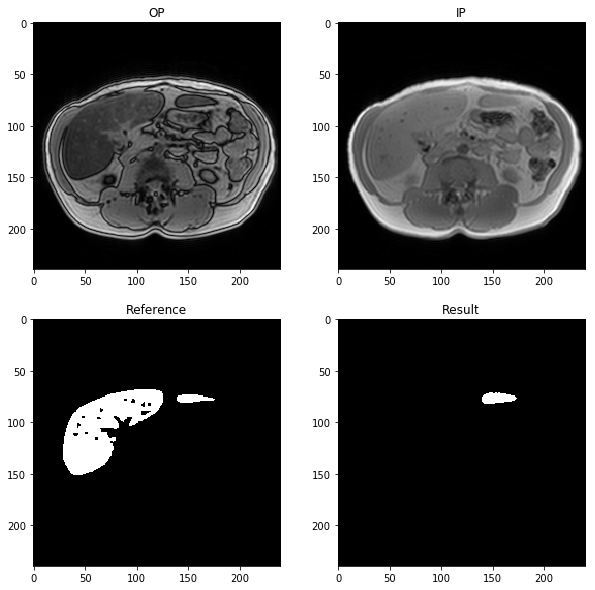

10
10
10
10
10
10


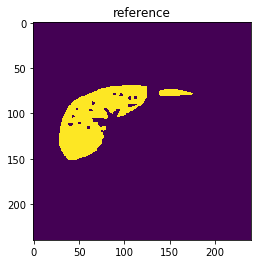

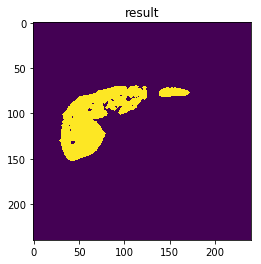

In [147]:
# S01-13_pedaço_MENOR

result_s01_13_1, dice_s01_13_1, jacc_s01_13_1, accu_s01_13_1, sens_s01_13_1, spec_s01_13_1, tempo_s01_13_1 = start_segm(inputOP, inputIP, inputref)

final_s01_13, dice_f, jacc_f, accu_f, sens_f, spec_f, tempo_f = junta_imgs(inputref, result_s01_13, result_s01_13_1)

misc.imsave('result_s01_13_10.bmp', final_s01_13)

listaDICE_S01_13.append(dice_f)
listaJACC_S01_13.append(jacc_f)
listaACCU_S01_13.append(accu_f)
listaSENS_S01_13.append(sens_f)
listaSPEC_S01_13.append(spec_f)
listaTEMPO_S01_13.append(tempo_f)

print(len(listaDICE_S01_13))
print(len(listaJACC_S01_13))
print(len(listaACCU_S01_13))
print(len(listaSENS_S01_13))
print(len(listaSPEC_S01_13))
print(len(listaTEMPO_S01_13))

plt.imshow(inputref)
plt.title('reference')
plt.show()
plt.imshow(final_s01_13)
plt.title('result')
plt.show()

del(inputOP)
del(inputIP)
del(inputref)

In [177]:
listaDICE_S01_15 = []
listaJACC_S01_15 = []
listaACCU_S01_15 = []
listaSENS_S01_15 = []
listaSPEC_S01_15 = []
listaTEMPO_S01_15 = []

[(43, 145), (70, 135), (48, 113), (56, 85), (75, 99), (79, 77), (101, 74), (120, 80)]
(101, 74)


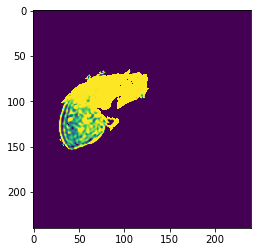

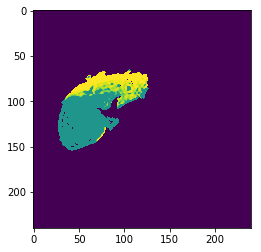

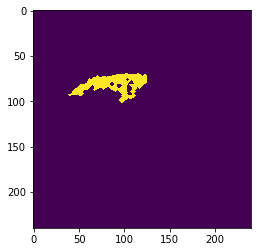

(48, 113)


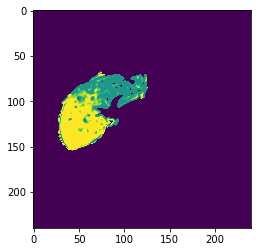

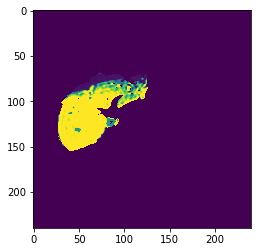

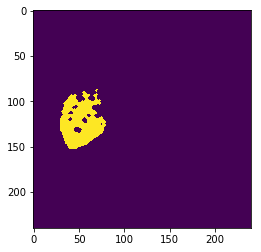

(75, 99)


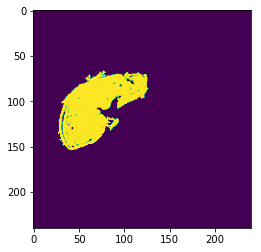

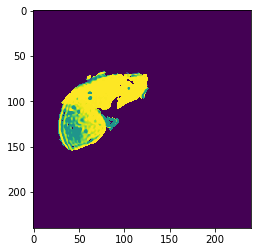

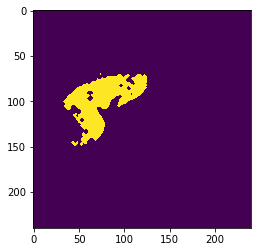

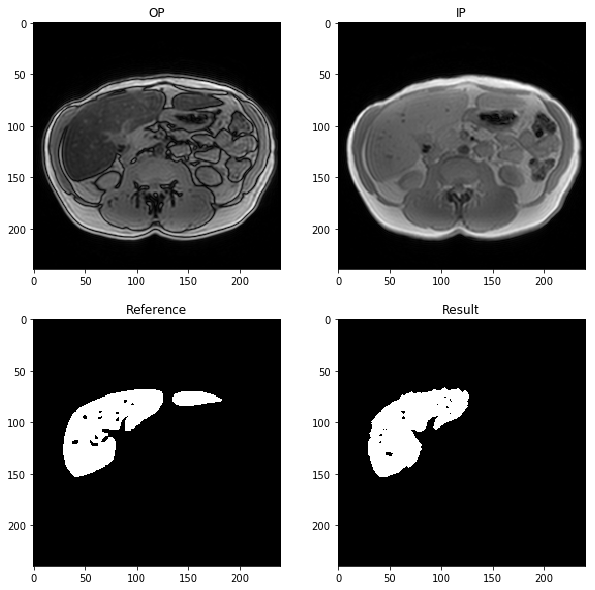

In [199]:
# S01-15_pedaço_MAIOR

inputOP = np.genfromtxt("dataset01\s01-15-op-228.txt")
inputIP = np.genfromtxt("dataset01\s01-15-ip-437.txt")
inputref = np.genfromtxt("dataset01\s01-15-ref.txt")

result_s01_15, dice_s01_15, jacc_s01_15, accu_s01_15, sens_s01_15, spec_s01_15, tempo_s01_15 = start_segm(inputOP, inputIP, inputref)

[(146, 79), (167, 77)]
(167, 77)


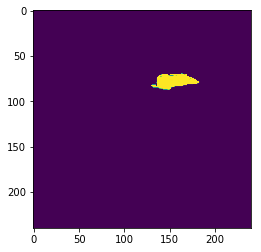

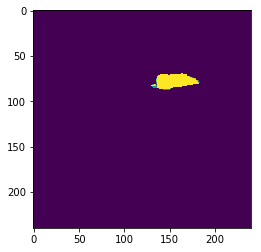

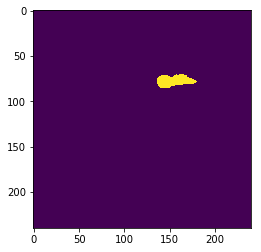

(146, 79)


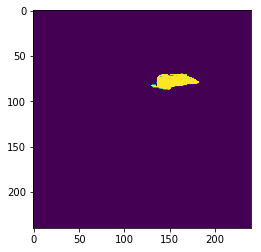

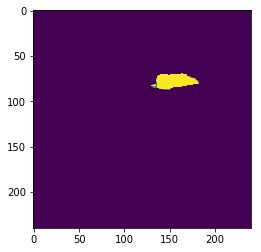

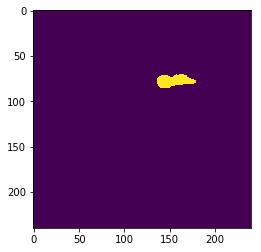

(146, 79)


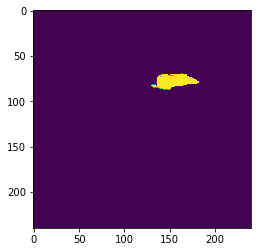

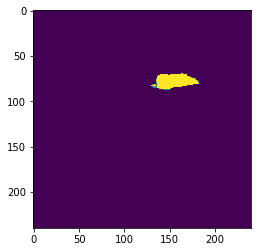

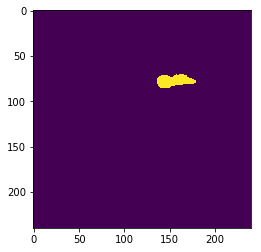

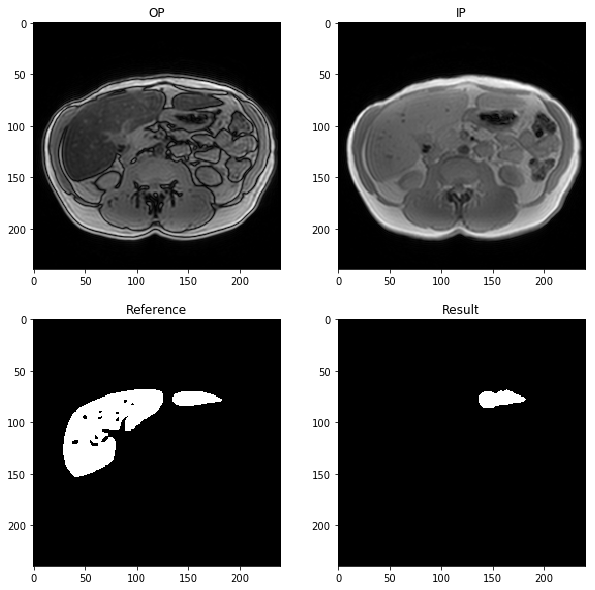

10
10
10
10
10
10


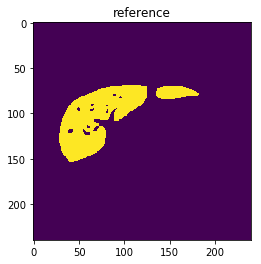

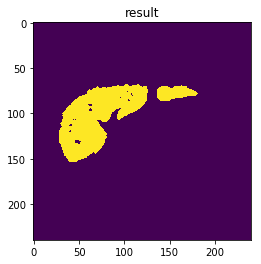

In [200]:
# S01-15_pedaço_MENOR

result_s01_15_1, dice_s01_15_1, jacc_s01_15_1, accu_s01_15_1, sens_s01_15_1, spec_s01_15_1, tempo_s01_15_1 = start_segm(inputOP, inputIP, inputref)

final_s01_15, dice_f15, jacc_f15, accu_f15, sens_f15, spec_f15, tempo_f15 = junta_imgs(inputref, result_s01_15, result_s01_15_1)

misc.imsave('result_s01_15_10.bmp', final_s01_15)

listaDICE_S01_15.append(dice_f15)
listaJACC_S01_15.append(jacc_f15)
listaACCU_S01_15.append(accu_f15)
listaSENS_S01_15.append(sens_f15)
listaSPEC_S01_15.append(spec_f15)
listaTEMPO_S01_15.append(tempo_f15+tempo_s01_15)

print(len(listaDICE_S01_15))
print(len(listaJACC_S01_15))
print(len(listaACCU_S01_15))
print(len(listaSENS_S01_15))
print(len(listaSPEC_S01_15))
print(len(listaTEMPO_S01_15))

plt.imshow(inputref)
plt.title('reference')
plt.show()
plt.imshow(final_s01_15)
plt.title('result')
plt.show()

del(inputOP)
del(inputIP)
del(inputref)

In [201]:
listaDICE_S01_17 = []
listaJACC_S01_17 = []
listaACCU_S01_17 = []
listaSENS_S01_17 = []
listaSPEC_S01_17 = []
listaTEMPO_S01_17 = []

[(46, 150), (71, 132), (49, 118), (62, 108), (65, 88), (92, 91), (115, 87)]
(92, 91)


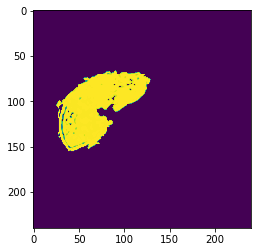

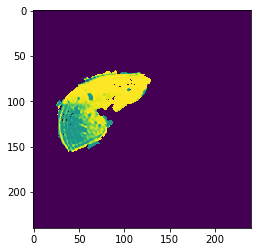

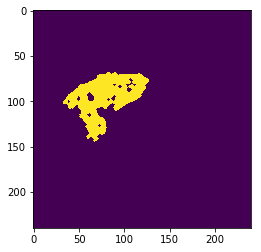

(46, 150)


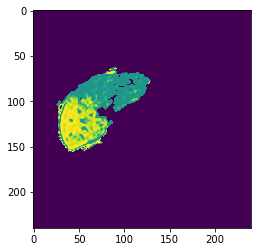

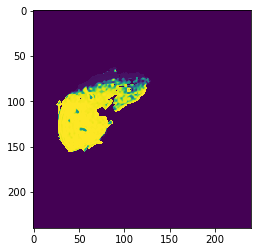

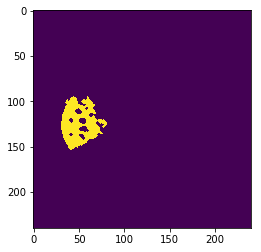

(71, 132)


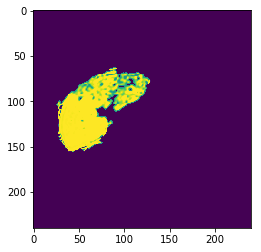

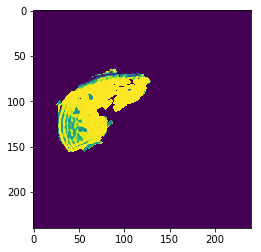

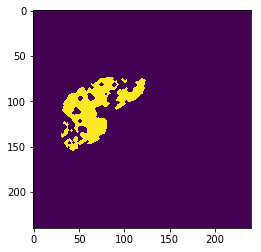

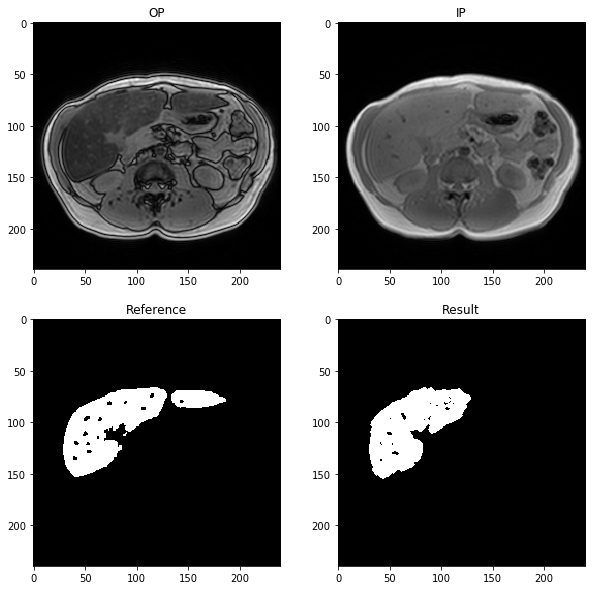

In [224]:
# S01-17_pedaço_MAIOR

inputOP = np.genfromtxt("dataset01\s01-17-op-229.txt")
inputIP = np.genfromtxt("dataset01\s01-17-ip-435.txt")
inputref = np.genfromtxt("dataset01\s01-17-ref.txt")

result_s01_17, dice_s01_17, jacc_s01_17, accu_s01_17, sens_s01_17, spec_s01_17, tempo_s01_17 = start_segm(inputOP, inputIP, inputref)

[(144, 75), (158, 77), (176, 80)]
(144, 75)


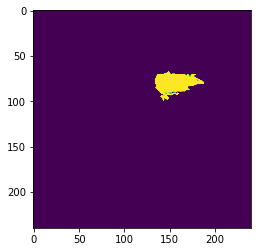

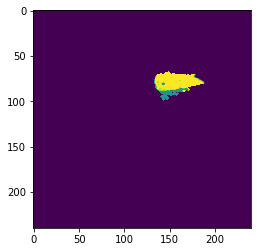

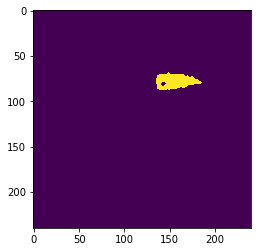

(176, 80)


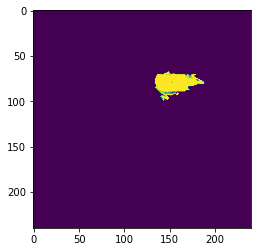

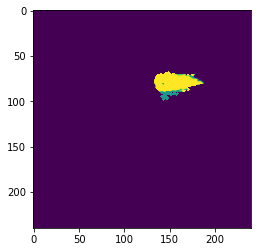

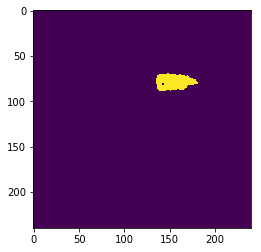

(158, 77)


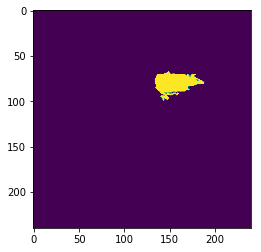

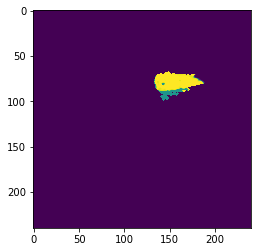

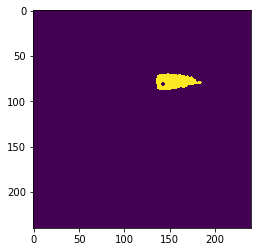

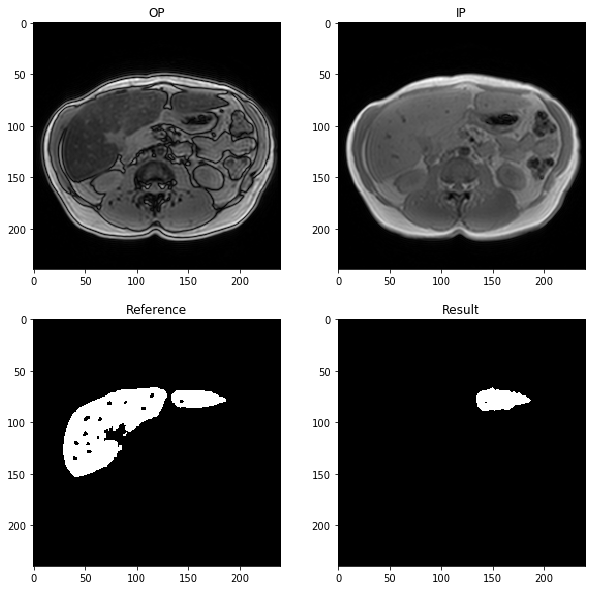

10
10
10
10
10
10


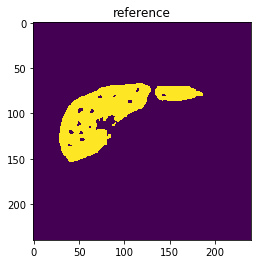

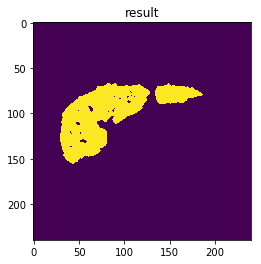

In [225]:
# S01-17_pedaço_MENOR

result_s01_17_1, dice_s01_17_1, jacc_s01_17_1, accu_s01_17_1, sens_s01_17_1, spec_s01_17_1, tempo_s01_17_1 = start_segm(inputOP, inputIP, inputref)

final_s01_17, dice_f17, jacc_f17, accu_f17, sens_f17, spec_f17, tempo_f17 = junta_imgs(inputref, result_s01_17, result_s01_17_1)

misc.imsave('result_s01_17_10.bmp', final_s01_17)

listaDICE_S01_17.append(dice_f17)
listaJACC_S01_17.append(jacc_f17)
listaACCU_S01_17.append(accu_f17)
listaSENS_S01_17.append(sens_f17)
listaSPEC_S01_17.append(spec_f17)
listaTEMPO_S01_17.append(tempo_f17+tempo_s01_17)

print(len(listaDICE_S01_17))
print(len(listaJACC_S01_17))
print(len(listaACCU_S01_17))
print(len(listaSENS_S01_17))
print(len(listaSPEC_S01_17))
print(len(listaTEMPO_S01_17))

plt.imshow(inputref)
plt.title('reference')
plt.show()
plt.imshow(final_s01_17)
plt.title('result')
plt.show()

del(inputOP)
del(inputIP)
del(inputref)

In [226]:
listaDICE_S01_19 = []
listaJACC_S01_19 = []
listaACCU_S01_19 = []
listaSENS_S01_19 = []
listaSPEC_S01_19 = []
listaTEMPO_S01_19 = []

[(66, 141), (45, 150), (38, 137), (38, 118), (42, 103), (64, 85), (110, 68), (119, 73), (102, 100), (60, 107), (62, 123)]
(110, 68)


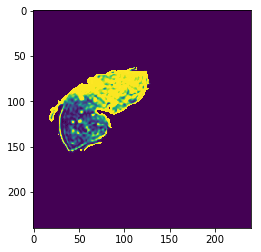

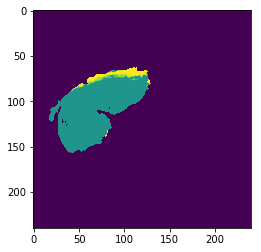

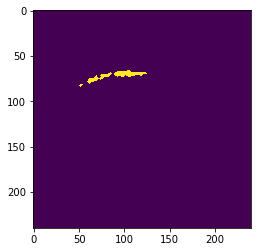

(45, 150)


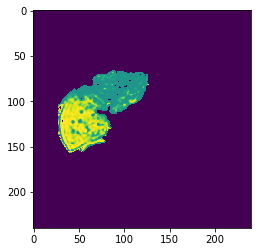

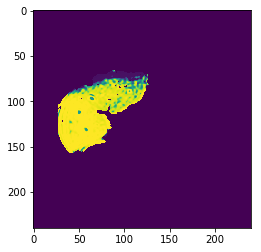

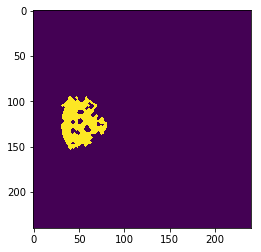

(60, 107)


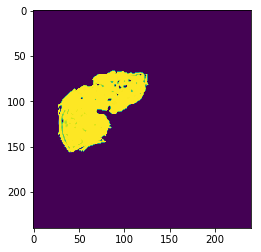

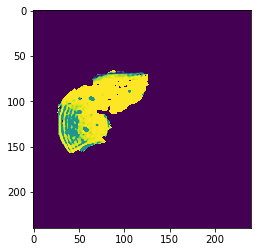

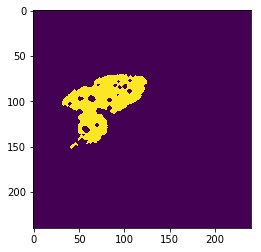

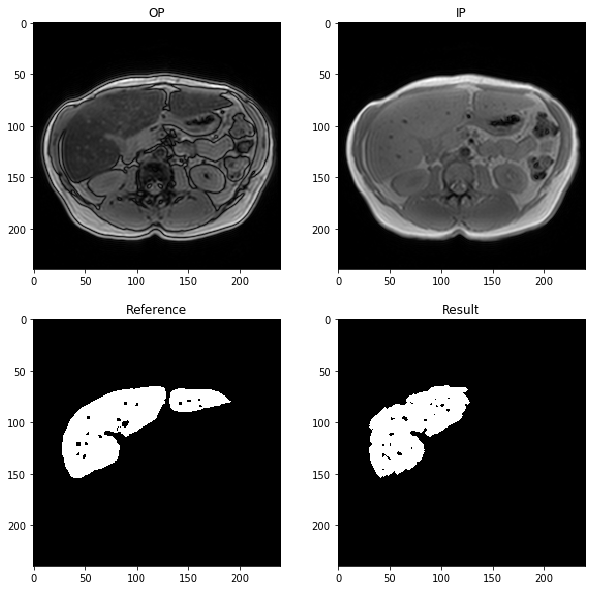

In [253]:
# S01-19_pedaço_MAIOR

inputOP = np.genfromtxt("dataset01\s01-19-op-227.txt")
inputIP = np.genfromtxt("dataset01\s01-19-ip-430.txt")
inputref = np.genfromtxt("dataset01\s01-19-ref.txt")

result_s01_19, dice_s01_19, jacc_s01_19, accu_s01_19, sens_s01_19, spec_s01_19, tempo_s01_19 = start_segm(inputOP, inputIP, inputref)

[(141, 77), (157, 77), (175, 78), (183, 78)]
(183, 78)


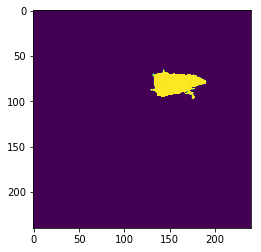

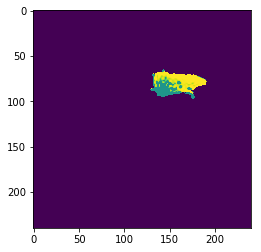

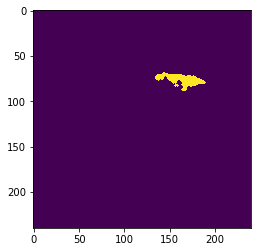

(175, 78)


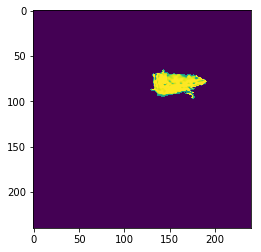

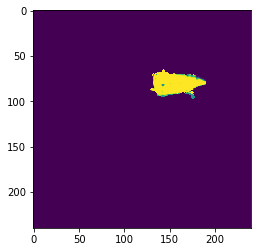

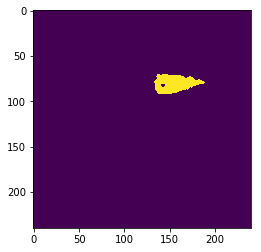

(141, 77)


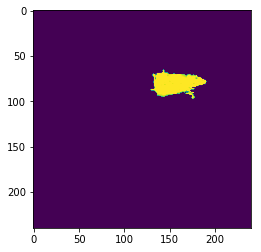

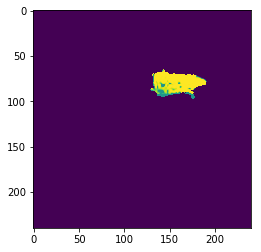

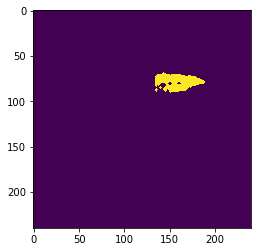

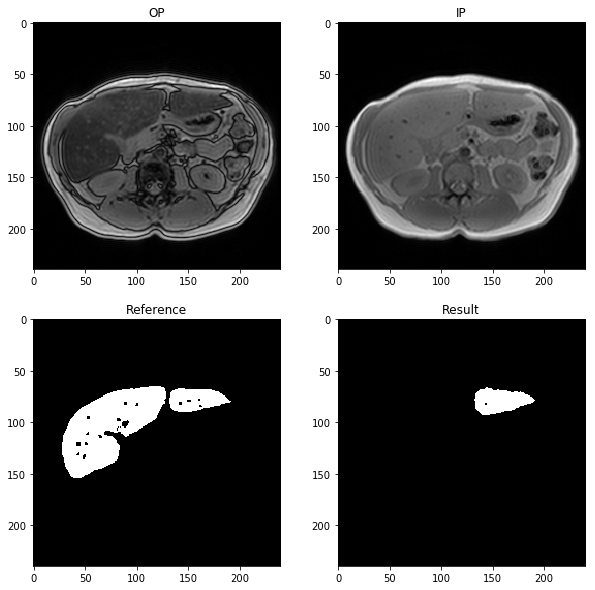

10
10
10
10
10
10


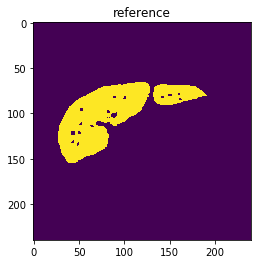

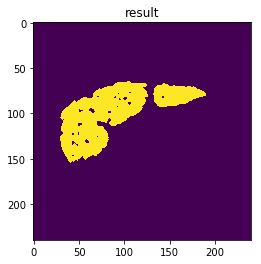

In [254]:
# S01-19_pedaço_MENOR

result_s01_19_1, dice_f19_1, jacc_f19_1, accu_f19_1, sens_f19_1, spec_f19_1, tempo_f19_1 = start_segm(inputOP, inputIP, inputref)

final_s01_19, dice_f19, jacc_f19, accu_f19, sens_f19, spec_f19, tempo_f19 = junta_imgs(inputref, result_s01_19, result_s01_19_1)

misc.imsave('result_s01_19_10.bmp', final_s01_19)

listaDICE_S01_19.append(dice_f19)
listaJACC_S01_19.append(jacc_f19)
listaACCU_S01_19.append(accu_f19)
listaSENS_S01_19.append(sens_f19)
listaSPEC_S01_19.append(spec_f19)
listaTEMPO_S01_19.append(tempo_f19+tempo_s01_19)

print(len(listaDICE_S01_19))
print(len(listaJACC_S01_19))
print(len(listaACCU_S01_19))
print(len(listaSENS_S01_19))
print(len(listaSPEC_S01_19))
print(len(listaTEMPO_S01_19))

plt.imshow(inputref)
plt.title('reference')
plt.show()
plt.imshow(final_s01_19)
plt.title('result')
plt.show()

del(inputOP)
del(inputIP)
del(inputref)

In [255]:
listaDICE_S01_21 = []
listaJACC_S01_21 = []
listaACCU_S01_21 = []
listaSENS_S01_21 = []
listaSPEC_S01_21 = []
listaTEMPO_S01_21 = []

[(120, 74), (88, 71), (66, 81), (43, 106), (41, 116), (34, 129), (41, 147), (56, 138), (76, 134), (68, 121), (63, 107), (96, 105), (112, 90)]
(66, 81)


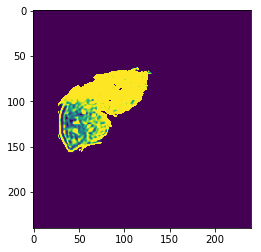

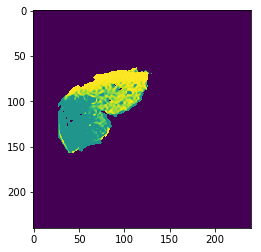

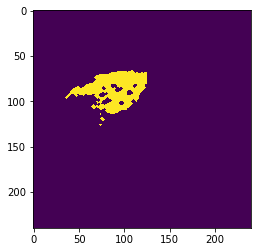

(41, 116)


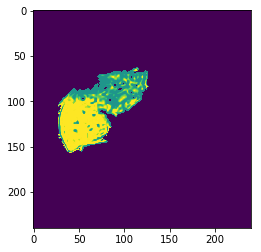

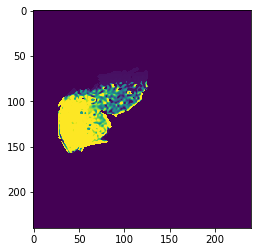

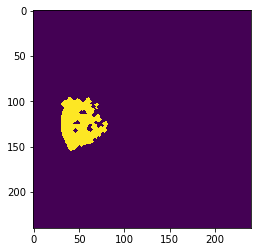

(63, 107)


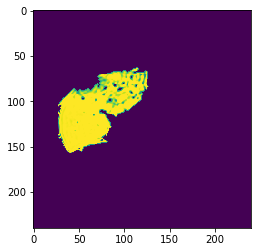

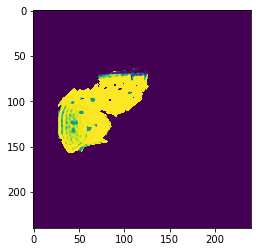

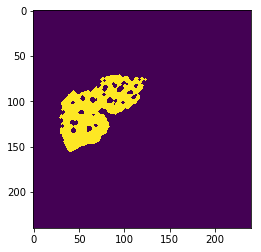

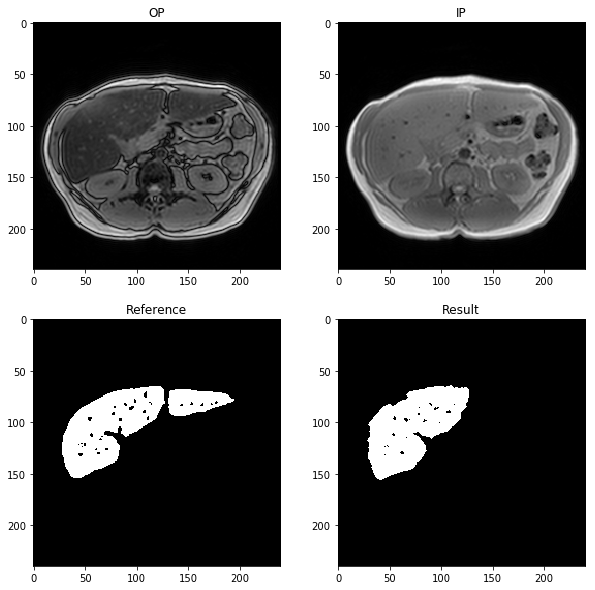

In [287]:
# S01-21_pedaço_MAIOR

inputOP = np.genfromtxt("dataset01\s01-21-op-223.txt")
inputIP = np.genfromtxt("dataset01\s01-21-ip-426.txt")
inputref = np.genfromtxt("dataset01\s01-21-ref.txt")

result_s01_21, dice_s01_21, jacc_s01_21, accu_s01_21, sens_s01_21, spec_s01_21, tempo_s01_21 = start_segm(inputOP, inputIP, inputref)

[(169, 75), (158, 77), (147, 74), (136, 76), (147, 89), (159, 88)]
(169, 75)


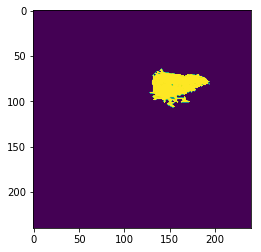

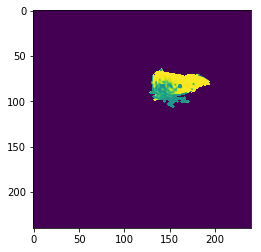

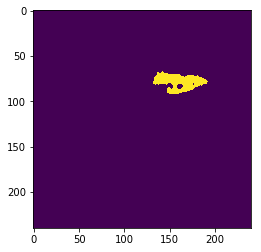

(159, 88)


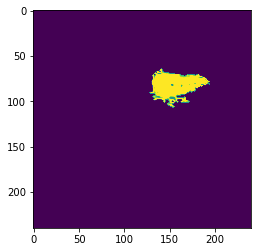

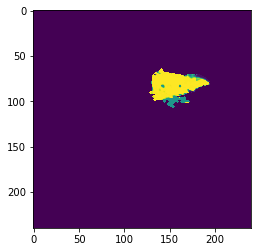

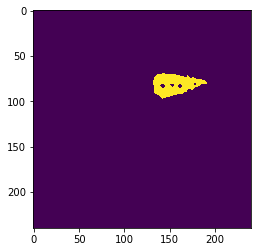

(147, 74)


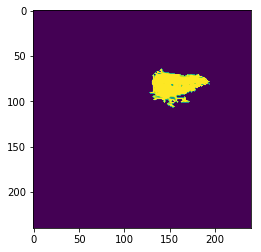

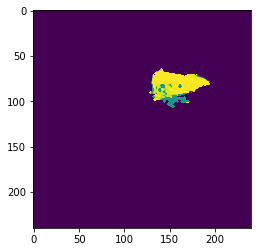

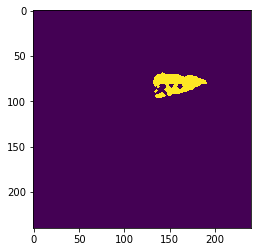

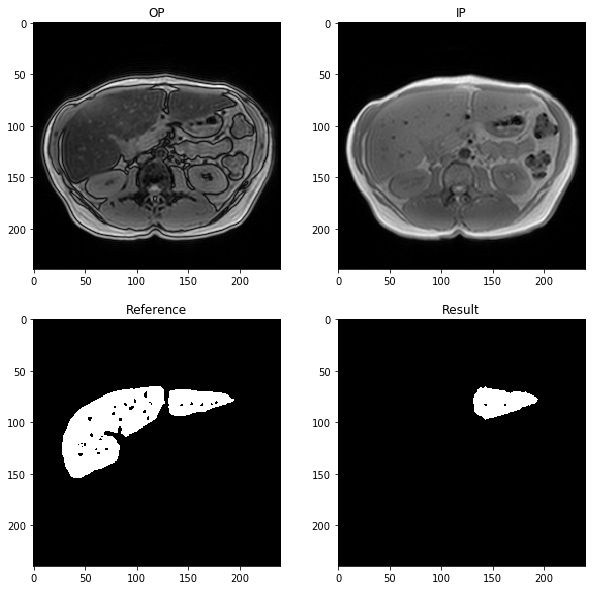

10
10
10
10
10
10


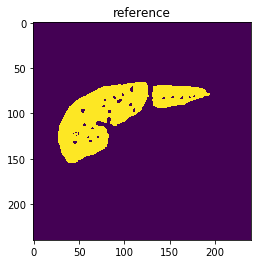

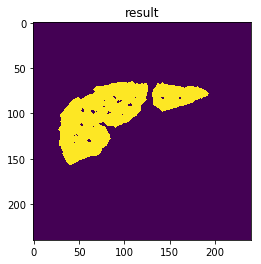

In [288]:
# S01-21_pedaço_MENOR

result_s01_21_1, dice_f21_1, jacc_f21_1, accu_f21_1, sens_f21_1, spec_f21_1, tempo_f21_1 = start_segm(inputOP, inputIP, inputref)

final_s01_21, dice_f21, jacc_f21, accu_f21, sens_f21, spec_f21, tempo_f21 = junta_imgs(inputref, result_s01_21, result_s01_21_1)

misc.imsave('result_s01_21_10.bmp', final_s01_21)

listaDICE_S01_21.append(dice_f21)
listaJACC_S01_21.append(jacc_f21)
listaACCU_S01_21.append(accu_f21)
listaSENS_S01_21.append(sens_f21)
listaSPEC_S01_21.append(spec_f21)
listaTEMPO_S01_21.append(tempo_f21+tempo_s01_21)

print(len(listaDICE_S01_21))
print(len(listaJACC_S01_21))
print(len(listaACCU_S01_21))
print(len(listaSENS_S01_21))
print(len(listaSPEC_S01_21))
print(len(listaTEMPO_S01_21))

plt.imshow(inputref)
plt.title('reference')
plt.show()
plt.imshow(final_s01_21)
plt.title('result')
plt.show()

del(inputOP)
del(inputIP)
del(inputref)

In [300]:
listaDICE_S01_23 = []
listaJACC_S01_23 = []
listaACCU_S01_23 = []
listaSENS_S01_23 = []
listaSPEC_S01_23 = []
listaTEMPO_S01_23 = []

[(117, 76), (95, 74), (80, 77), (63, 81), (53, 88), (53, 104), (44, 113), (40, 119), (38, 128), (37, 138), (47, 149), (57, 144), (76, 138), (56, 124), (65, 123), (63, 108), (77, 96), (88, 108), (102, 101), (121, 77)]
(63, 81)


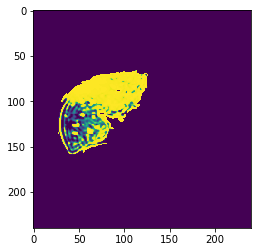

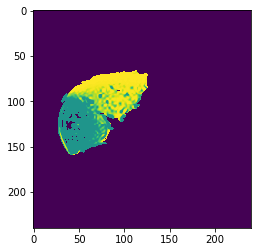

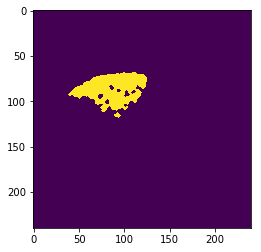

(38, 128)


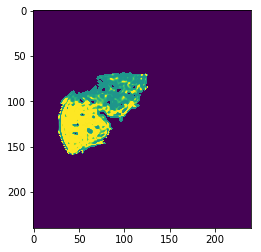

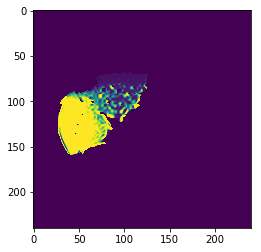

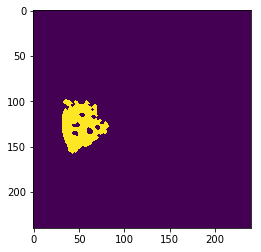

(77, 96)


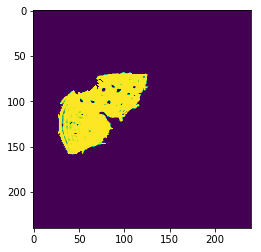

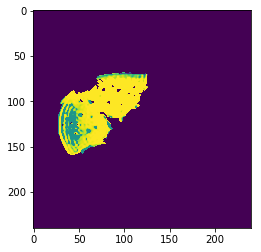

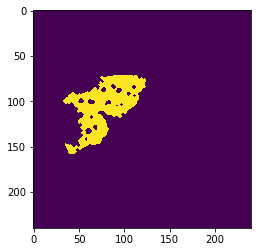

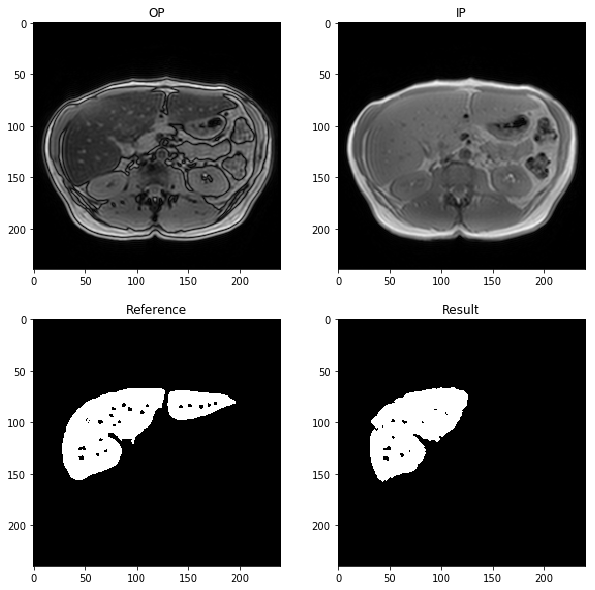

In [327]:
# S01-23_pedaço_MAIOR

inputOP = np.genfromtxt("dataset01\s01-23-op-227.txt")
inputIP = np.genfromtxt("dataset01\s01-23-ip-430.txt")
inputref = np.genfromtxt("dataset01\s01-23-ref.txt")

result_s01_23, dice_s01_23, jacc_s01_23, accu_s01_23, sens_s01_23, spec_s01_23, tempo_s01_23 = start_segm(inputOP, inputIP, inputref)

[(189, 80), (175, 74), (160, 75), (145, 75), (137, 78)]
(189, 80)


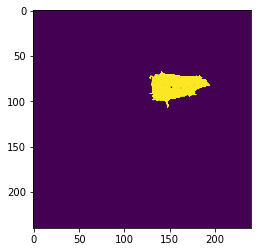

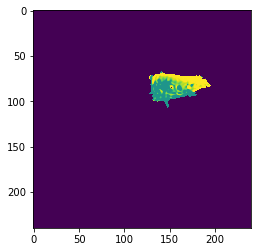

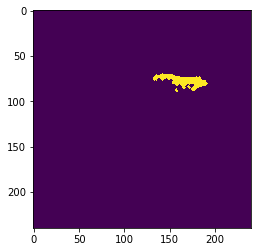

(137, 78)


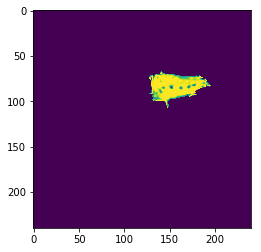

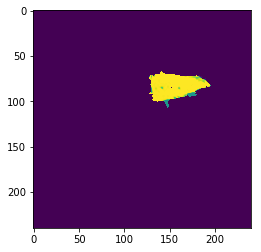

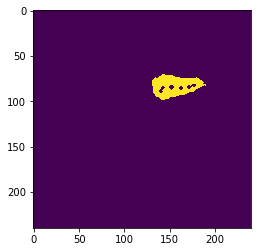

(160, 75)


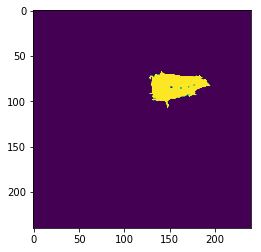

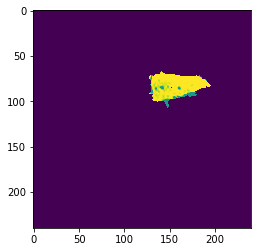

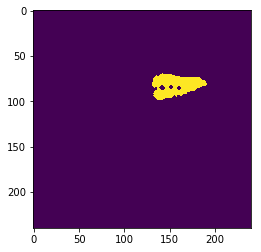

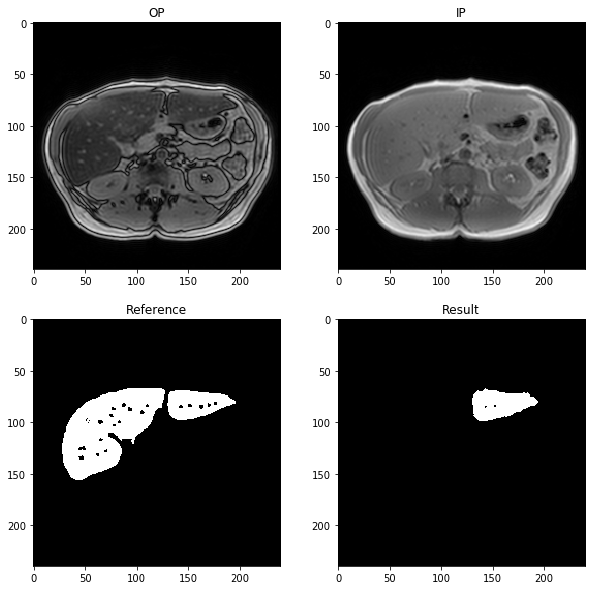

10
10
10
10
10
10


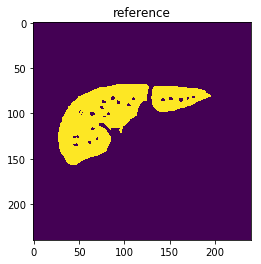

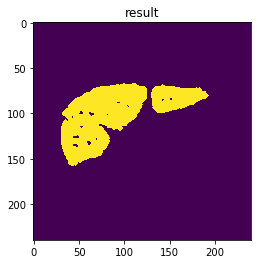

In [328]:
# S01-23_pedaço_MENOR

result_s01_23_1, dice_f23_1, jacc_f23_1, accu_f23_1, sens_f23_1, spec_f23_1, tempo_f23_1 = start_segm(inputOP, inputIP, inputref)

final_s01_23, dice_f23, jacc_f23, accu_f23, sens_f23, spec_f23, tempo_f23 = junta_imgs(inputref, result_s01_23, result_s01_23_1)

misc.imsave('result_s01_23_10.bmp', final_s01_23)

listaDICE_S01_23.append(dice_f23)
listaJACC_S01_23.append(jacc_f23)
listaACCU_S01_23.append(accu_f23)
listaSENS_S01_23.append(sens_f23)
listaSPEC_S01_23.append(spec_f23)
listaTEMPO_S01_23.append(tempo_f23+tempo_s01_23)

print(len(listaDICE_S01_23))
print(len(listaJACC_S01_23))
print(len(listaACCU_S01_23))
print(len(listaSENS_S01_23))
print(len(listaSPEC_S01_23))
print(len(listaTEMPO_S01_23))

plt.imshow(inputref)
plt.title('reference')
plt.show()
plt.imshow(final_s01_23)
plt.title('result')
plt.show()

del(inputOP)
del(inputIP)
del(inputref)

In [364]:
listaDICE_S01_25 = []
listaJACC_S01_25 = []
listaACCU_S01_25 = []
listaSENS_S01_25 = []
listaSPEC_S01_25 = []
listaTEMPO_S01_25 = []

[(46, 149), (56, 136), (76, 131), (64, 122), (35, 128), (42, 111), (54, 90), (77, 82), (94, 73), (119, 76), (94, 97), (107, 102)]
(54, 90)


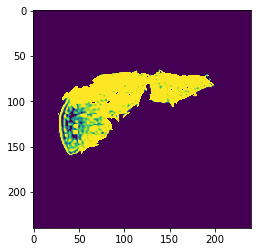

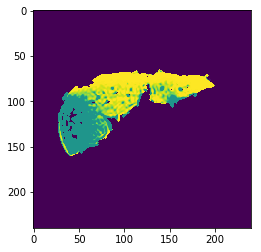

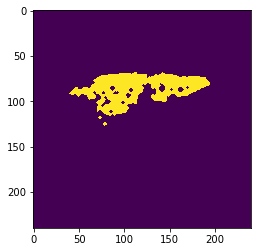

(42, 111)


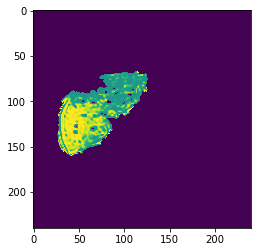

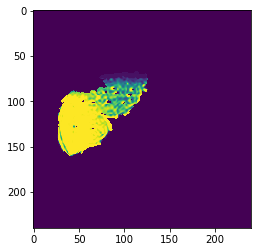

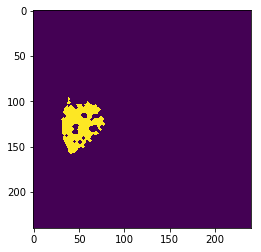

(76, 131)


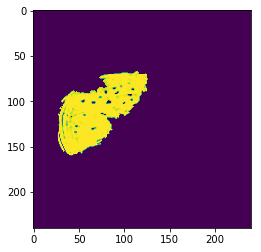

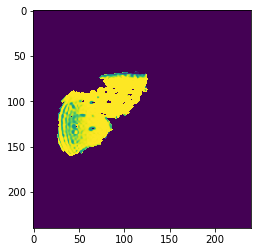

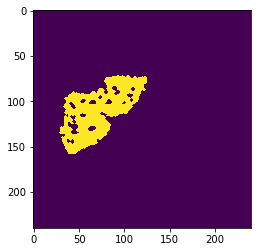

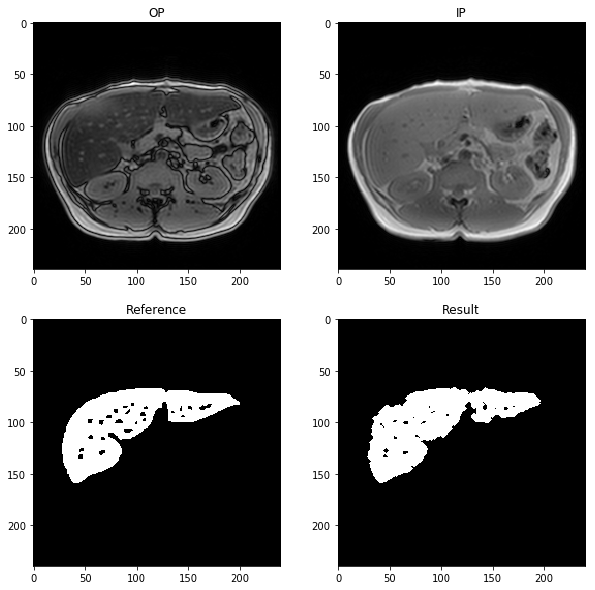

10
10
10
10
10
10


In [374]:
# S01-25

inputOP = np.genfromtxt("dataset01\s01-25-op-230.txt")
inputIP = np.genfromtxt("dataset01\s01-25-ip-433.txt")
inputref = np.genfromtxt("dataset01\s01-25-ref.txt")

result_s01_25, dice_f25, jacc_f25, accu_f25, sens_f25, spec_f25, tempo_f25 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_25_10.bmp', result_s01_25)

listaDICE_S01_25.append(dice_f25)
listaJACC_S01_25.append(jacc_f25)
listaACCU_S01_25.append(accu_f25)
listaSENS_S01_25.append(sens_f25)
listaSPEC_S01_25.append(spec_f25)
listaTEMPO_S01_25.append(tempo_f25)

print(len(listaDICE_S01_25))
print(len(listaJACC_S01_25))
print(len(listaACCU_S01_25))
print(len(listaSENS_S01_25))
print(len(listaSPEC_S01_25))
print(len(listaTEMPO_S01_25))

del(inputOP)
del(inputIP)
del(inputref)

In [376]:
listaDICE_S01_27 = []
listaJACC_S01_27 = []
listaACCU_S01_27 = []
listaSENS_S01_27 = []
listaSPEC_S01_27 = []
listaTEMPO_S01_27 = []

[(42, 154), (57, 145), (77, 138), (79, 126), (46, 119), (57, 107), (59, 93), (72, 83), (97, 78), (116, 78), (140, 78), (153, 78), (175, 78), (188, 81)]
(72, 83)


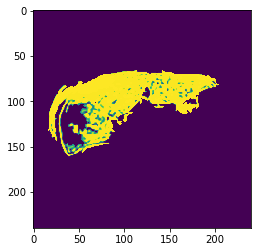

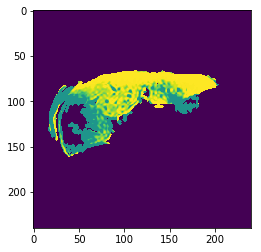

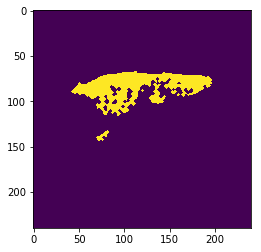

(46, 119)


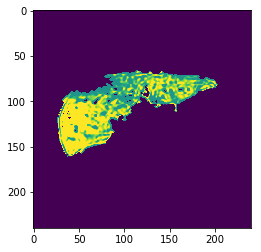

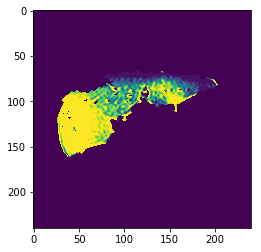

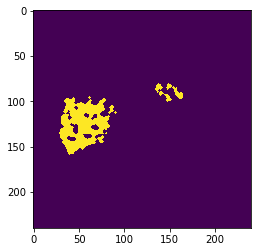

(97, 78)


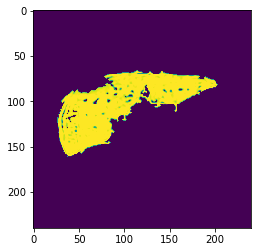

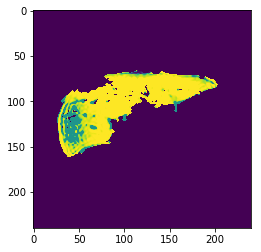

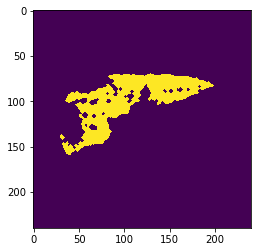

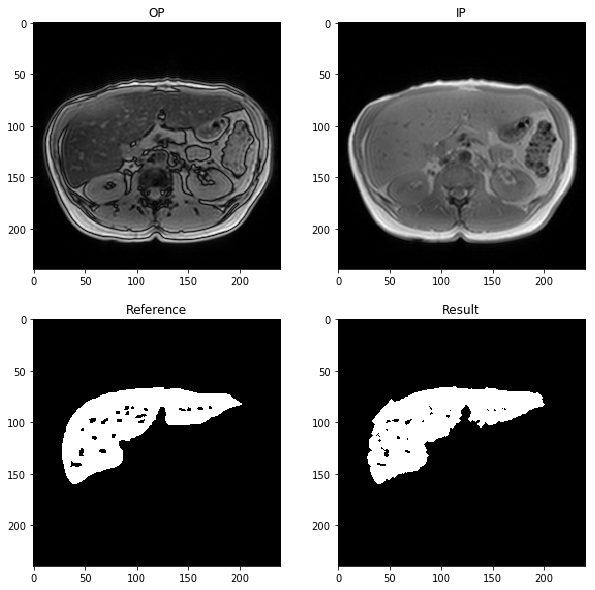

10
10
10
10
10
10


In [388]:
# S01-27

inputOP = np.genfromtxt("dataset01\s01-27-op-231.txt")
inputIP = np.genfromtxt("dataset01\s01-27-ip-432.txt")
inputref = np.genfromtxt("dataset01\s01-27-ref.txt")

result_s01_27, dice_f27, jacc_f27, accu_f27, sens_f27, spec_f27, tempo_f27 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_27_10.bmp', result_s01_27)

listaDICE_S01_27.append(dice_f27)
listaJACC_S01_27.append(jacc_f27)
listaACCU_S01_27.append(accu_f27)
listaSENS_S01_27.append(sens_f27)
listaSPEC_S01_27.append(spec_f27)
listaTEMPO_S01_27.append(tempo_f27)

print(len(listaDICE_S01_27))
print(len(listaJACC_S01_27))
print(len(listaACCU_S01_27))
print(len(listaSENS_S01_27))
print(len(listaSPEC_S01_27))
print(len(listaTEMPO_S01_27))

del(inputOP)
del(inputIP)
del(inputref)

In [394]:
listaDICE_S01_29 = []
listaJACC_S01_29 = []
listaACCU_S01_29 = []
listaSENS_S01_29 = []
listaSPEC_S01_29 = []
listaTEMPO_S01_29 = []

[(40, 153), (58, 143), (75, 140), (73, 122), (52, 126), (57, 110), (50, 96), (69, 78), (82, 78), (96, 79), (107, 79), (115, 85), (126, 76), (145, 73), (154, 80), (173, 79), (183, 83)]
(69, 78)


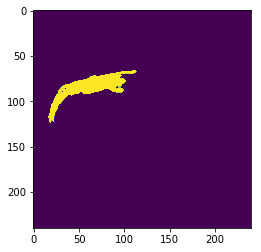

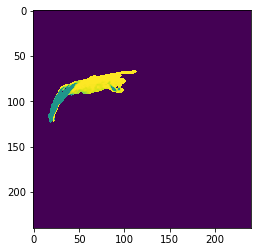

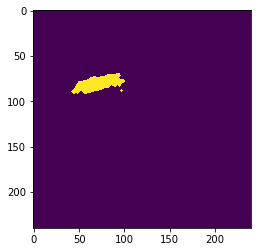

(40, 153)


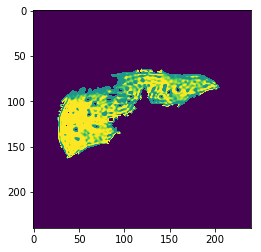

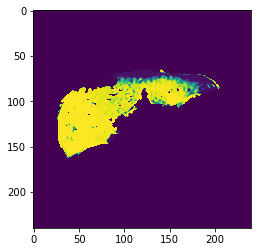

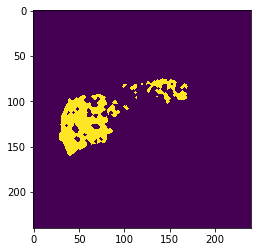

(50, 96)


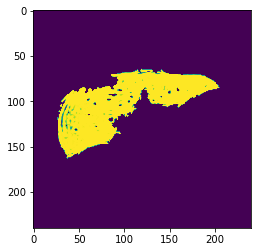

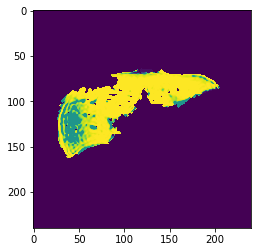

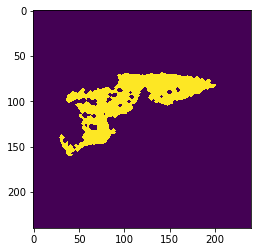

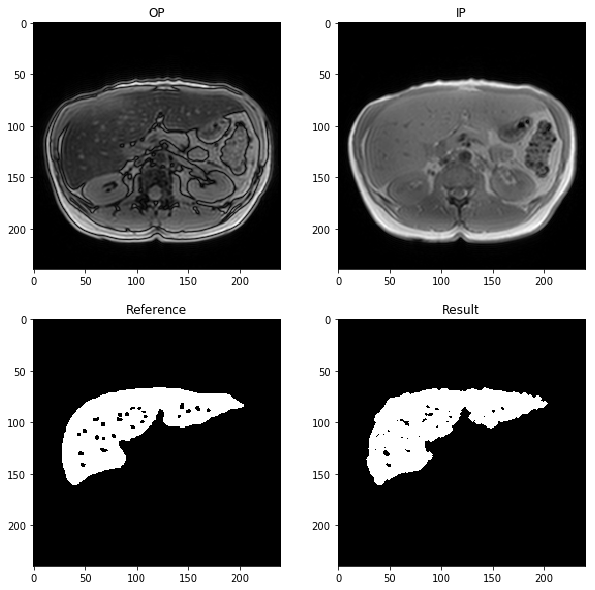

10
10
10
10
10
10


In [406]:
# S01-29

inputOP = np.genfromtxt("dataset01\s01-29-op-229.txt")
inputIP = np.genfromtxt("dataset01\s01-29-ip-434.txt")
inputref = np.genfromtxt("dataset01\s01-29-ref.txt")

result_s01_29, dice_f29, jacc_f29, accu_f29, sens_f29, spec_f29, tempo_f29 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_29_10.bmp', result_s01_29)

listaDICE_S01_29.append(dice_f29)
listaJACC_S01_29.append(jacc_f29)
listaACCU_S01_29.append(accu_f29)
listaSENS_S01_29.append(sens_f29)
listaSPEC_S01_29.append(spec_f29)
listaTEMPO_S01_29.append(tempo_f29)

print(len(listaDICE_S01_29))
print(len(listaJACC_S01_29))
print(len(listaACCU_S01_29))
print(len(listaSENS_S01_29))
print(len(listaSPEC_S01_29))
print(len(listaTEMPO_S01_29))

del(inputOP)
del(inputIP)
del(inputref)

In [408]:
listaDICE_S01_31 = []
listaJACC_S01_31 = []
listaACCU_S01_31 = []
listaSENS_S01_31 = []
listaSPEC_S01_31 = []
listaTEMPO_S01_31 = []

[(36, 148), (35, 129), (35, 111), (50, 94), (73, 82), (91, 78), (109, 75), (125, 72), (140, 73), (153, 74), (173, 78), (189, 78), (159, 94), (76, 95), (58, 120), (63, 145)]
(91, 78)


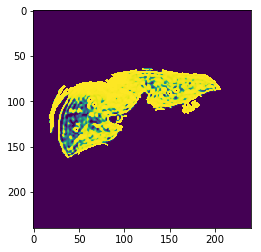

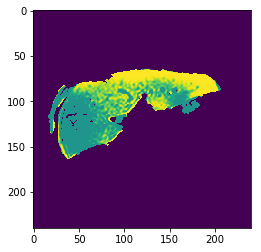

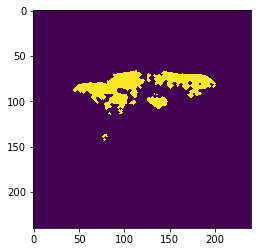

(35, 111)


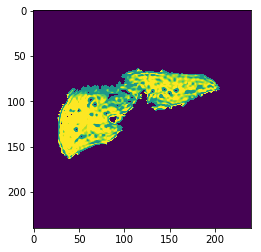

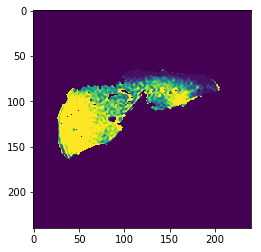

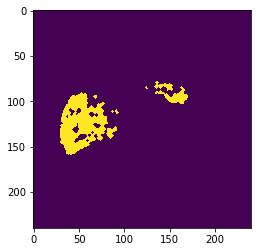

(63, 145)


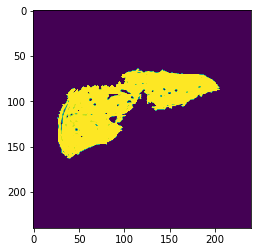

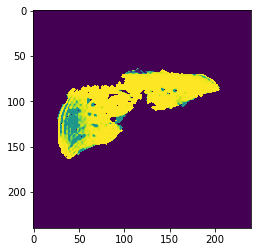

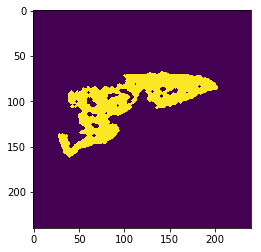

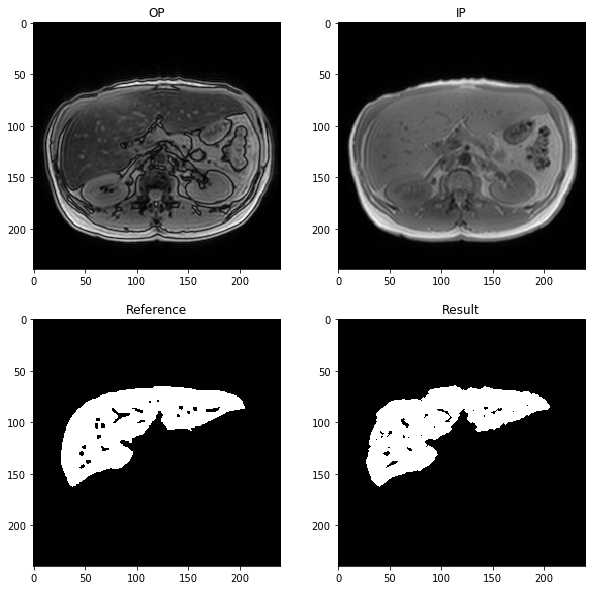

10
10
10
10
10
10


In [425]:
# S01-31

inputOP = np.genfromtxt("dataset01\s01-31-op-231.txt")
inputIP = np.genfromtxt("dataset01\s01-31-ip-436.txt")
inputref = np.genfromtxt("dataset01\s01-31-ref.txt")

result_s01_31, dice_f31, jacc_f31, accu_f31, sens_f31, spec_f31, tempo_f31 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_31_10.bmp', result_s01_31)

listaDICE_S01_31.append(dice_f31)
listaJACC_S01_31.append(jacc_f31)
listaACCU_S01_31.append(accu_f31)
listaSENS_S01_31.append(sens_f31)
listaSPEC_S01_31.append(spec_f31)
listaTEMPO_S01_31.append(tempo_f31)

print(len(listaDICE_S01_31))
print(len(listaJACC_S01_31))
print(len(listaACCU_S01_31))
print(len(listaSENS_S01_31))
print(len(listaSPEC_S01_31))
print(len(listaTEMPO_S01_31))

del(inputOP)
del(inputIP)
del(inputref)

In [437]:
listaDICE_S01_33 = []
listaJACC_S01_33 = []
listaACCU_S01_33 = []
listaSENS_S01_33 = []
listaSPEC_S01_33 = []
listaTEMPO_S01_33 = []

[(45, 147), (54, 126), (89, 78), (154, 78)]
(89, 78)


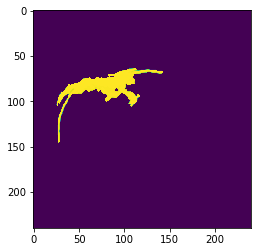

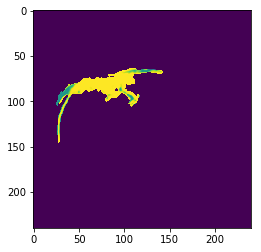

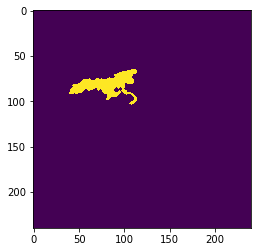

(45, 147)


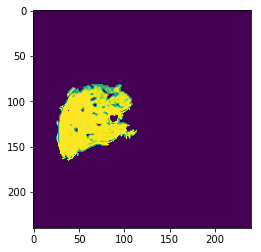

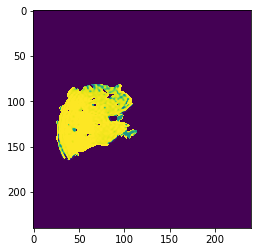

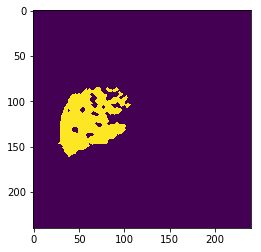

(154, 78)


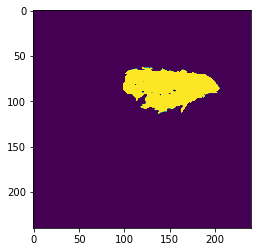

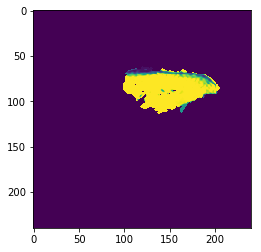

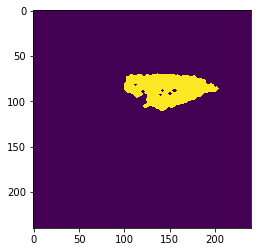

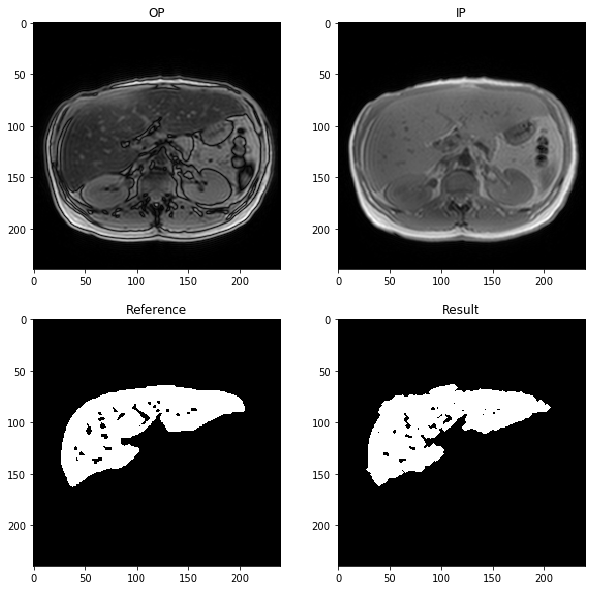

In [20]:
# S01-33

inputOP = np.genfromtxt("dataset01\s01-33-op.txt")
inputIP = np.genfromtxt("dataset01\s01-33-ip.txt")
inputref = np.genfromtxt("dataset01\s01-33-ref.txt")

result_s01_33, dice_f33, jacc_f33, accu_f33, sens_f33, spec_f33, tempo_f33 = start_segm(inputOP, inputIP, inputref)

[(118, 71), (142, 74), (156, 75), (172, 77), (187, 84), (194, 84), (172, 93), (145, 100)]
(118, 71)


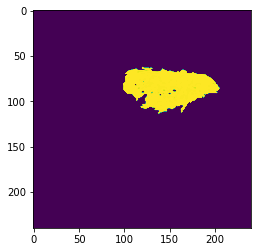

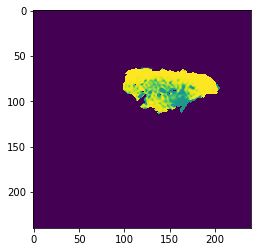

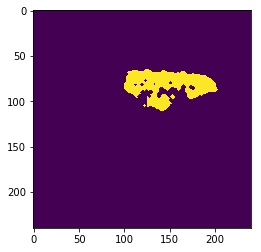

(194, 84)


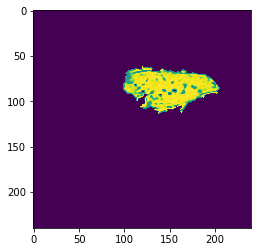

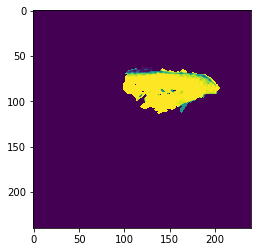

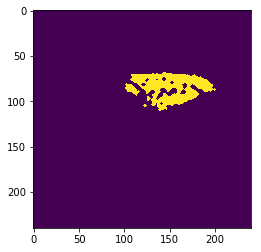

(172, 77)


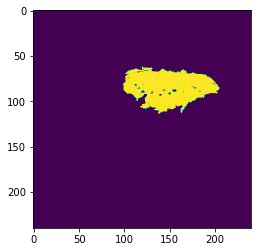

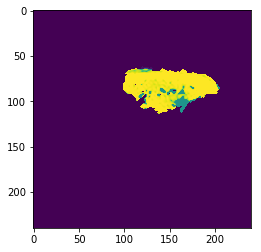

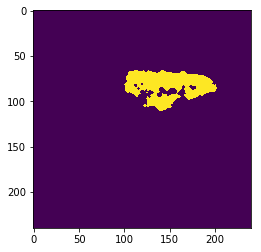

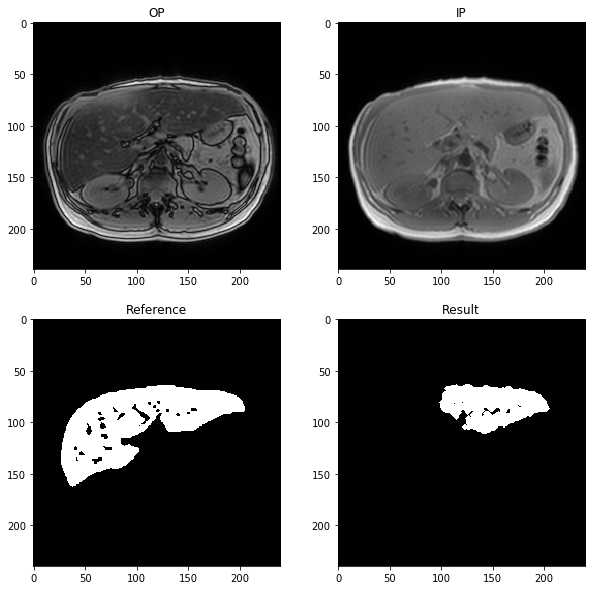

10
10
10
10
10
10


In [457]:
result_s01_33_1, dice_f33_1, jacc_f33_1, accu_f33_1, sens_f33_1, spec_f33_1, tempo_f33_1 = start_segm(inputOP, inputIP, inputref)

final_s01_33, dice_f331, jacc_f331, accu_f331, sens_f331, spec_f331, tempo_f331 = junta_imgs(inputref, result_s01_33, result_s01_33_1)

misc.imsave('result_s01_33_10.bmp', final_s01_33)

listaDICE_S01_33.append(dice_f331)
listaJACC_S01_33.append(jacc_f331)
listaACCU_S01_33.append(accu_f331)
listaSENS_S01_33.append(sens_f331)
listaSPEC_S01_33.append(spec_f331)
listaTEMPO_S01_33.append(tempo_f331)

print(len(listaDICE_S01_33))
print(len(listaJACC_S01_33))
print(len(listaACCU_S01_33))
print(len(listaSENS_S01_33))
print(len(listaSPEC_S01_33))
print(len(listaTEMPO_S01_33))

del(inputOP)
del(inputIP)
del(inputref)

In [458]:
listaDICE_S01_35 = []
listaJACC_S01_35 = []
listaACCU_S01_35 = []
listaSENS_S01_35 = []
listaSPEC_S01_35 = []
listaTEMPO_S01_35 = []

[(92, 131), (55, 147), (39, 155), (36, 138), (36, 121), (48, 105), (62, 88), (82, 82), (97, 73), (114, 73), (139, 73), (167, 74), (196, 82), (174, 93), (142, 101), (75, 94), (62, 120)]
(97, 73)


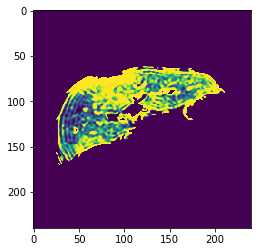

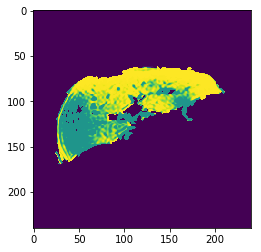

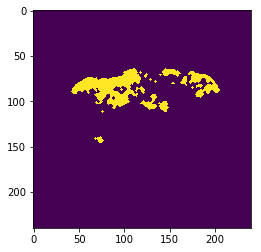

(36, 138)


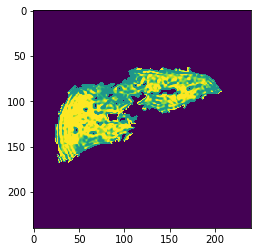

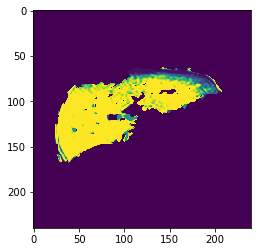

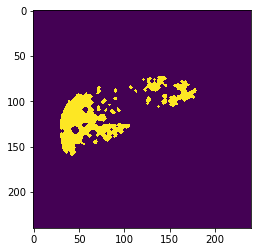

(114, 73)


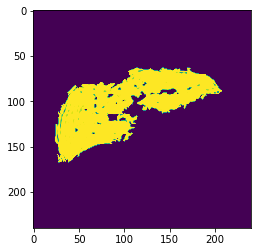

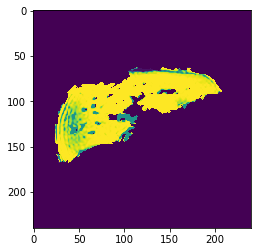

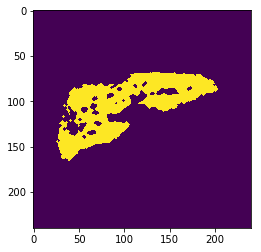

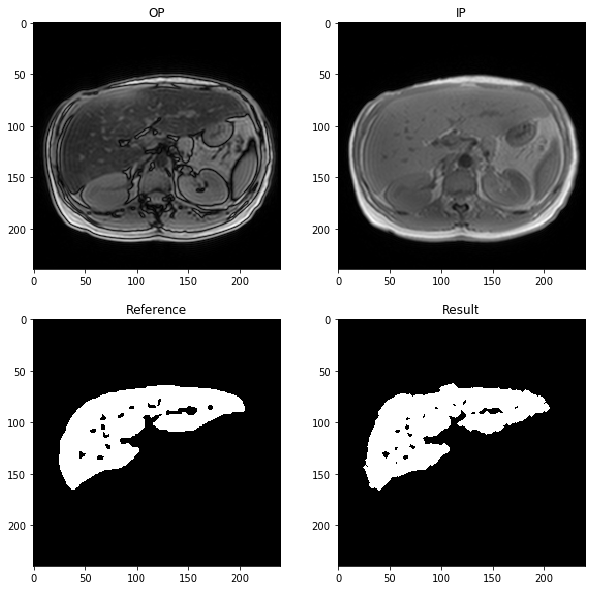

9
9
9
9
9
9


In [470]:
# S01-35

inputOP = np.genfromtxt("dataset01\s01-35-op-234.txt")
inputIP = np.genfromtxt("dataset01\s01-35-ip-440.txt")
inputref = np.genfromtxt("dataset01\s01-35-ref.txt")

result_s01_35, dice_f35, jacc_f35, accu_f35, sens_f35, spec_f35, tempo_f35 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_35_10.bmp', result_s01_35)

listaDICE_S01_35.append(dice_f35)
listaJACC_S01_35.append(jacc_f35)
listaACCU_S01_35.append(accu_f35)
listaSENS_S01_35.append(sens_f35)
listaSPEC_S01_35.append(spec_f35)
listaTEMPO_S01_35.append(tempo_f35)

print(len(listaDICE_S01_35))
print(len(listaJACC_S01_35))
print(len(listaACCU_S01_35))
print(len(listaSENS_S01_35))
print(len(listaSPEC_S01_35))
print(len(listaTEMPO_S01_35))

del(inputOP)
del(inputIP)
del(inputref)

In [478]:
listaDICE_S01_39 = []
listaJACC_S01_39 = []
listaACCU_S01_39 = []
listaSENS_S01_39 = []
listaSPEC_S01_39 = []
listaTEMPO_S01_39 = []

[(132, 106), (164, 96), (191, 80), (168, 77), (144, 74), (108, 69), (92, 71), (69, 77), (58, 82), (49, 97), (39, 118), (31, 134), (39, 164), (53, 144), (77, 140), (56, 115)]
(92, 71)


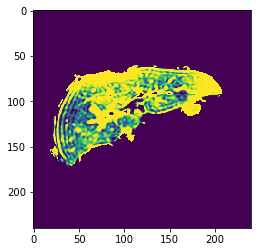

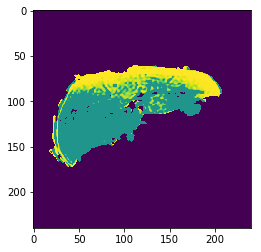

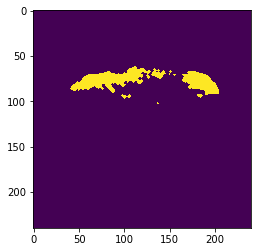

(39, 118)


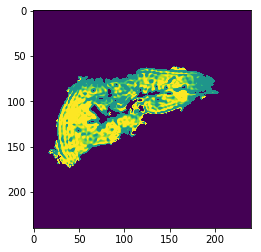

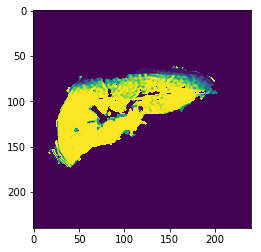

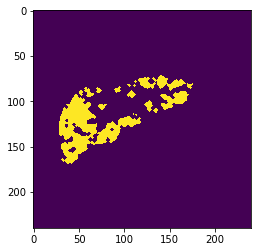

(168, 77)


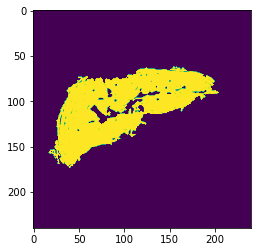

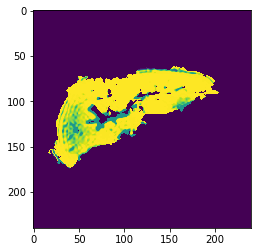

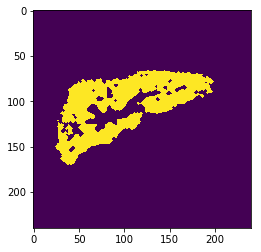

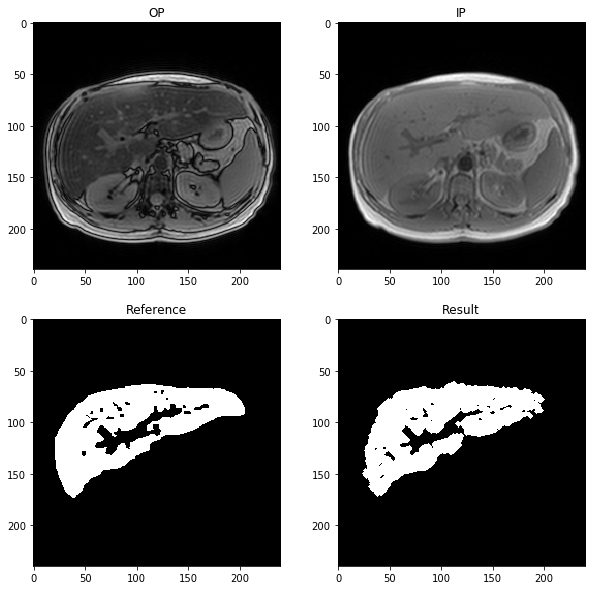

10
10
10
10
10
10


In [494]:
# S01-39

inputOP = np.genfromtxt("dataset01\s01-39-op-237.txt")
inputIP = np.genfromtxt("dataset01\s01-39-ip-441.txt")
inputref = np.genfromtxt("dataset01\s01-39-ref.txt")

result_s01_39, dice_f39, jacc_f39, accu_f39, sens_f39, spec_f39, tempo_f39 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_39_10.bmp', result_s01_39)

listaDICE_S01_39.append(dice_f39)
listaJACC_S01_39.append(jacc_f39)
listaACCU_S01_39.append(accu_f39)
listaSENS_S01_39.append(sens_f39)
listaSPEC_S01_39.append(spec_f39)
listaTEMPO_S01_39.append(tempo_f39)

print(len(listaDICE_S01_39))
print(len(listaJACC_S01_39))
print(len(listaACCU_S01_39))
print(len(listaSENS_S01_39))
print(len(listaSPEC_S01_39))
print(len(listaTEMPO_S01_39))

del(inputOP)
del(inputIP)
del(inputref)

In [483]:
listaDICE_S01_41 = []
listaJACC_S01_41 = []
listaACCU_S01_41 = []
listaSENS_S01_41 = []
listaSPEC_S01_41 = []
listaTEMPO_S01_41 = []

[(109, 125), (77, 139), (56, 151), (39, 165), (35, 146), (35, 141), (39, 118), (73, 76), (102, 73), (166, 73), (53, 114), (116, 116), (138, 106), (157, 99), (192, 86)]
(102, 73)


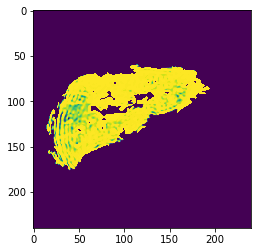

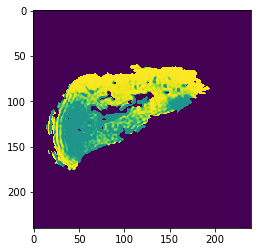

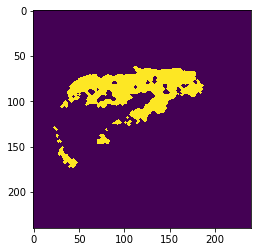

(39, 118)


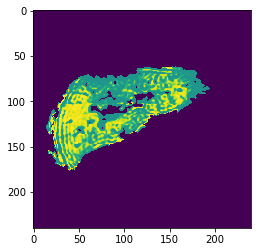

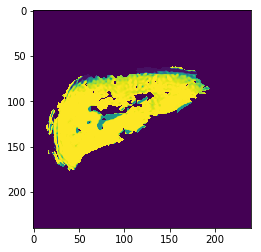

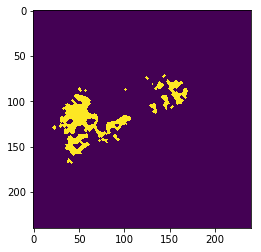

(116, 116)


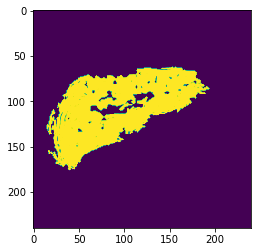

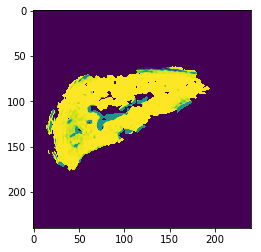

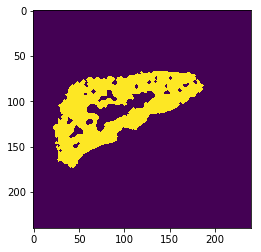

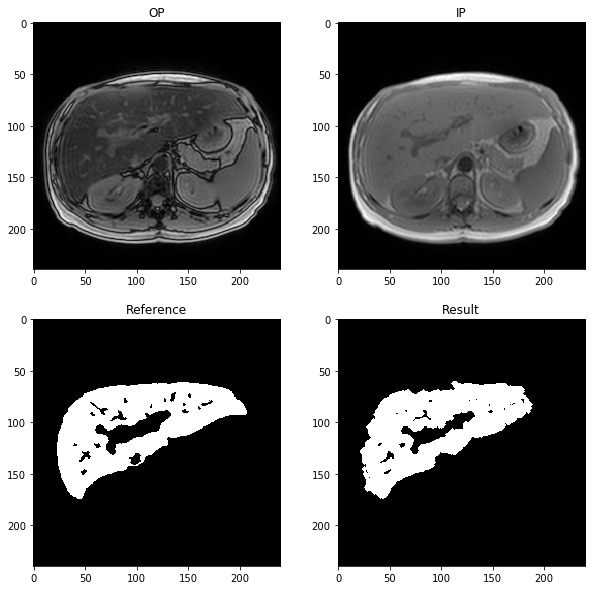

10
10
10
10
10
10


In [503]:
# S01-41

inputOP = np.genfromtxt("dataset01\s01-41-op-244.txt")
inputIP = np.genfromtxt("dataset01\s01-41-ip-443.txt")
inputref = np.genfromtxt("dataset01\s01-41-ref.txt")

result_s01_41, dice_f41, jacc_f41, accu_f41, sens_f41, spec_f41, tempo_f41 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_41_10.bmp', result_s01_41)

listaDICE_S01_41.append(dice_f41)
listaJACC_S01_41.append(jacc_f41)
listaACCU_S01_41.append(accu_f41)
listaSENS_S01_41.append(sens_f41)
listaSPEC_S01_41.append(spec_f41)
listaTEMPO_S01_41.append(tempo_f41)

print(len(listaDICE_S01_41))
print(len(listaJACC_S01_41))
print(len(listaACCU_S01_41))
print(len(listaSENS_S01_41))
print(len(listaSPEC_S01_41))
print(len(listaTEMPO_S01_41))

del(inputOP)
del(inputIP)
del(inputref)

In [496]:
listaDICE_S01_43 = []
listaJACC_S01_43 = []
listaACCU_S01_43 = []
listaSENS_S01_43 = []
listaSPEC_S01_43 = []
listaTEMPO_S01_43 = []

[(38, 151), (34, 131), (39, 111), (47, 91), (68, 79), (82, 79), (101, 72), (124, 74), (143, 73), (171, 74), (187, 82), (168, 92), (140, 103), (117, 120), (101, 123), (86, 135), (68, 146), (45, 152), (69, 119), (91, 103)]
(101, 72)


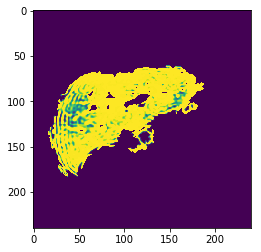

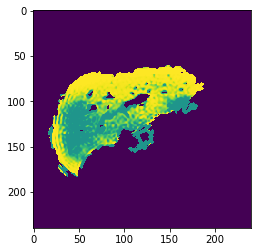

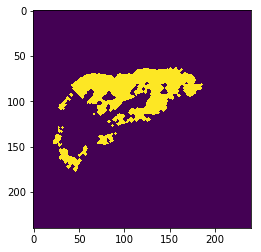

(34, 131)


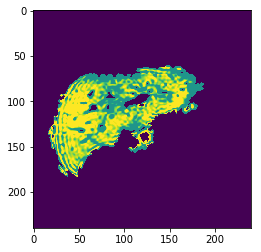

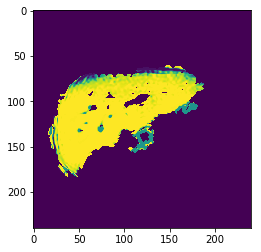

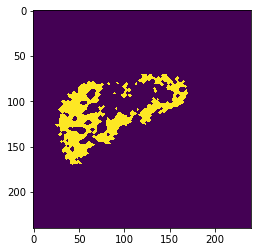

(101, 123)


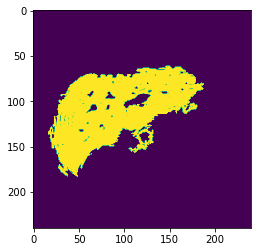

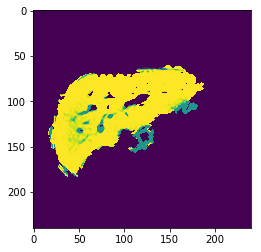

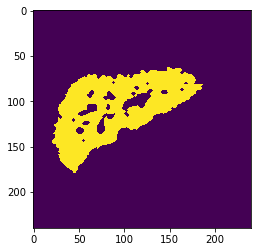

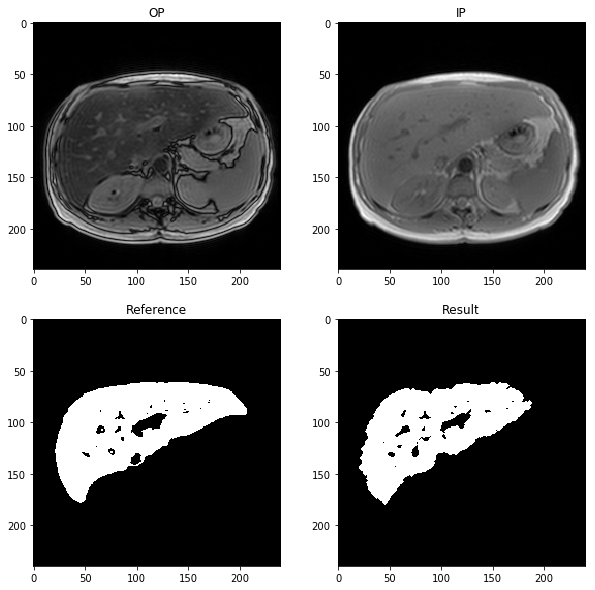

10
10
10
10
10
10


In [514]:
# S01-43

inputOP = np.genfromtxt("dataset01\s01-43-op-242.txt")
inputIP = np.genfromtxt("dataset01\s01-43-ip-449.txt")
inputref = np.genfromtxt("dataset01\s01-43-ref.txt")

result_s01_43, dice_f43, jacc_f43, accu_f43, sens_f43, spec_f43, tempo_f43 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_43_10.bmp', result_s01_43)

listaDICE_S01_43.append(dice_f43)
listaJACC_S01_43.append(jacc_f43)
listaACCU_S01_43.append(accu_f43)
listaSENS_S01_43.append(sens_f43)
listaSPEC_S01_43.append(spec_f43)
listaTEMPO_S01_43.append(tempo_f43)

print(len(listaDICE_S01_43))
print(len(listaJACC_S01_43))
print(len(listaACCU_S01_43))
print(len(listaSENS_S01_43))
print(len(listaSPEC_S01_43))
print(len(listaTEMPO_S01_43))

del(inputOP)
del(inputIP)
del(inputref)

In [506]:
listaDICE_S01_45 = []
listaJACC_S01_45 = []
listaACCU_S01_45 = []
listaSENS_S01_45 = []
listaSPEC_S01_45 = []
listaTEMPO_S01_45 = []

[(37, 149), (37, 131), (42, 110), (49, 91), (90, 74), (106, 74), (145, 72), (188, 80), (146, 101), (102, 117), (83, 134), (59, 151)]
(188, 80)


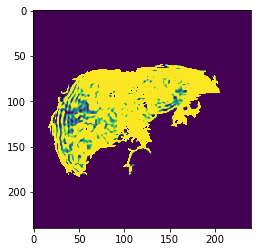

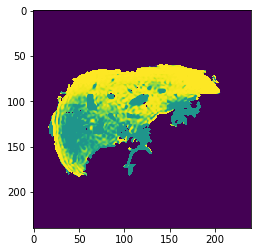

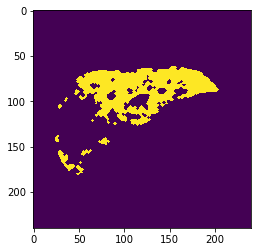

(42, 110)


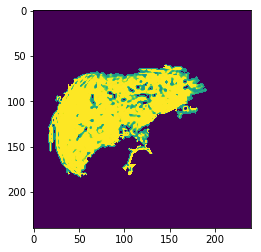

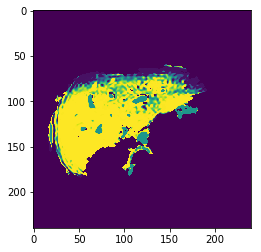

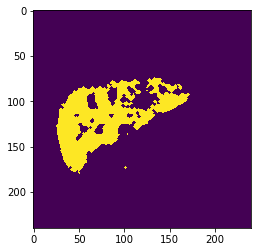

(83, 134)


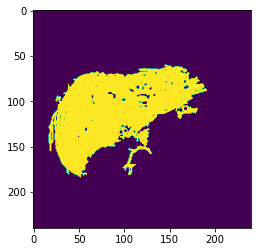

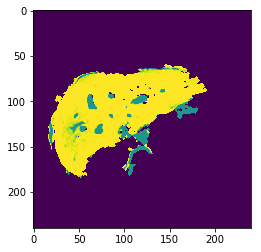

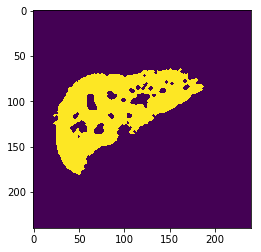

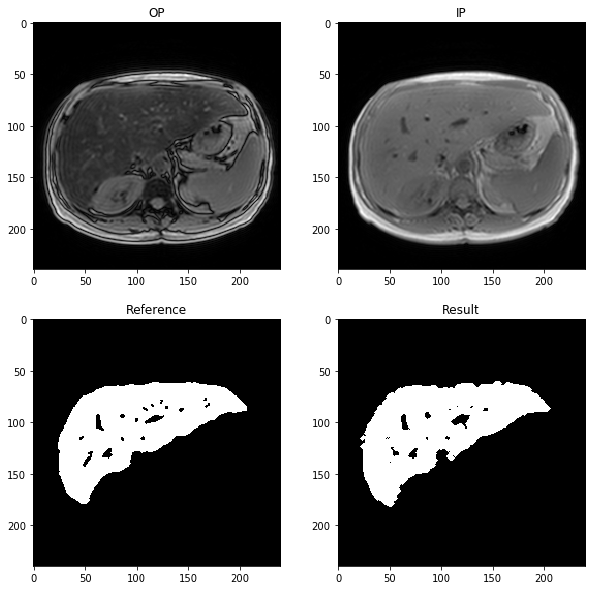

10
10
10
10
10
10


In [530]:
# S01-45

inputOP = np.genfromtxt("dataset01\s01-45-op-235.txt")
inputIP = np.genfromtxt("dataset01\s01-45-ip-448.txt")
inputref = np.genfromtxt("dataset01\s01-45-ref.txt")

result_s01_45, dice_f45, jacc_f45, accu_f45, sens_f45, spec_f45, tempo_f45 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_45_10.bmp', result_s01_45)

listaDICE_S01_45.append(dice_f45)
listaJACC_S01_45.append(jacc_f45)
listaACCU_S01_45.append(accu_f45)
listaSENS_S01_45.append(sens_f45)
listaSPEC_S01_45.append(spec_f45)
listaTEMPO_S01_45.append(tempo_f45)

print(len(listaDICE_S01_45))
print(len(listaJACC_S01_45))
print(len(listaACCU_S01_45))
print(len(listaSENS_S01_45))
print(len(listaSPEC_S01_45))
print(len(listaTEMPO_S01_45))

del(inputOP)
del(inputIP)
del(inputref)

In [522]:
listaDICE_S01_47 = []
listaJACC_S01_47 = []
listaACCU_S01_47 = []
listaSENS_S01_47 = []
listaSPEC_S01_47 = []
listaTEMPO_S01_47 = []

[(44, 164), (39, 145), (34, 123), (44, 102), (49, 93), (90, 72), (112, 71), (145, 70), (158, 76), (171, 71), (183, 75), (164, 93), (151, 102), (120, 119), (88, 128), (69, 149), (44, 157)]
(112, 71)


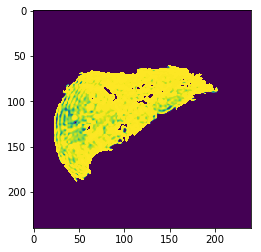

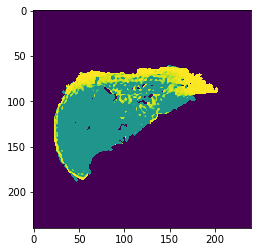

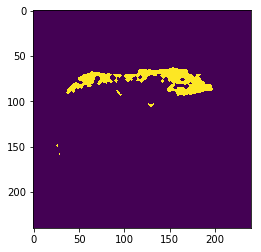

(49, 93)


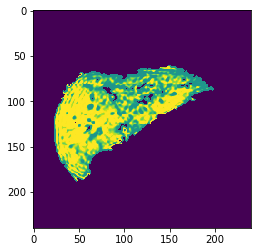

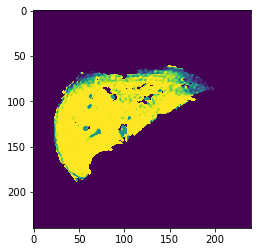

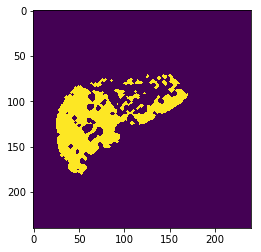

(120, 119)


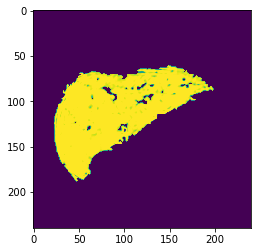

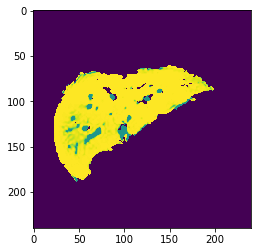

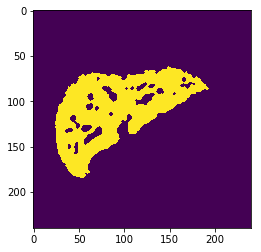

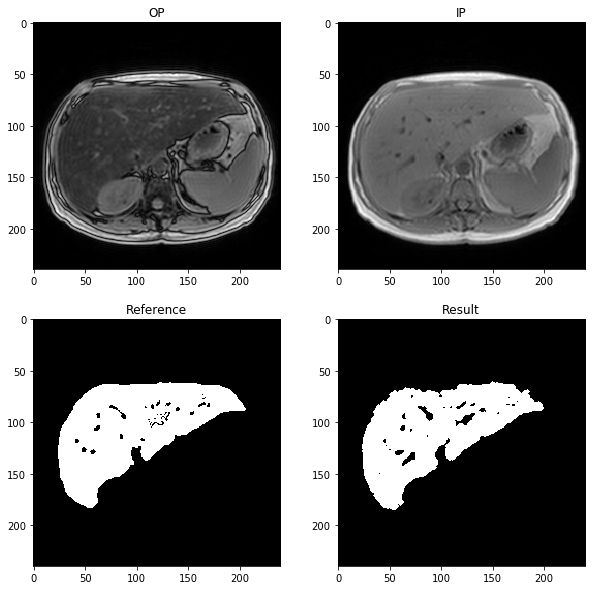

10
10
10
10
10
10


In [544]:
# S01-47

inputOP = np.genfromtxt("dataset01\s01-47-op-231.txt")
inputIP = np.genfromtxt("dataset01\s01-47-ip-445.txt")
inputref = np.genfromtxt("dataset01\s01-47-ref.txt")

result_s01_47, dice_f47, jacc_f47, accu_f47, sens_f47, spec_f47, tempo_f47 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_47_10.bmp', result_s01_47)

listaDICE_S01_47.append(dice_f47)
listaJACC_S01_47.append(jacc_f47)
listaACCU_S01_47.append(accu_f47)
listaSENS_S01_47.append(sens_f47)
listaSPEC_S01_47.append(spec_f47)
listaTEMPO_S01_47.append(tempo_f47)

print(len(listaDICE_S01_47))
print(len(listaJACC_S01_47))
print(len(listaACCU_S01_47))
print(len(listaSENS_S01_47))
print(len(listaSPEC_S01_47))
print(len(listaTEMPO_S01_47))

del(inputOP)
del(inputIP)
del(inputref)

In [535]:
listaDICE_S01_49 = []
listaJACC_S01_49 = []
listaACCU_S01_49 = []
listaSENS_S01_49 = []
listaSPEC_S01_49 = []
listaTEMPO_S01_49 = []

[(49, 164), (38, 148), (35, 128), (95, 74), (129, 72), (184, 74), (141, 106), (120, 121), (86, 144)]
(184, 74)


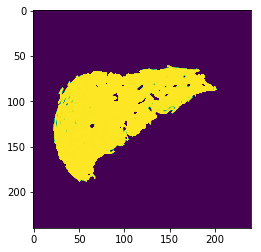

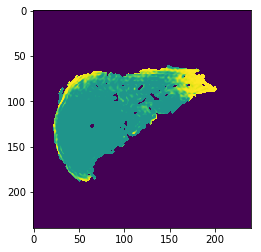

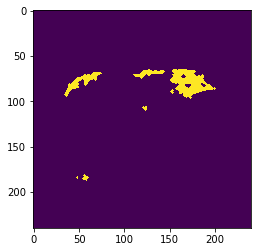

(35, 128)


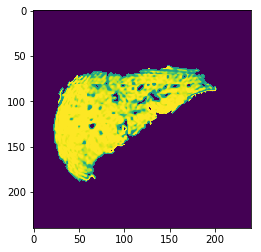

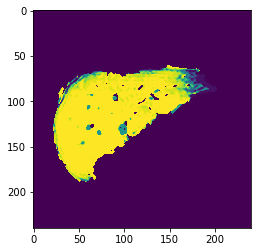

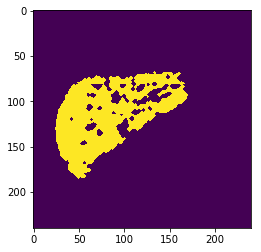

(120, 121)


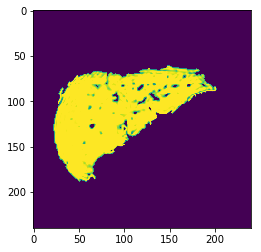

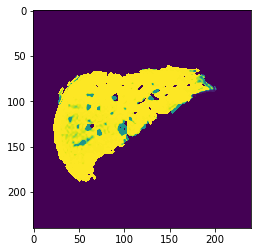

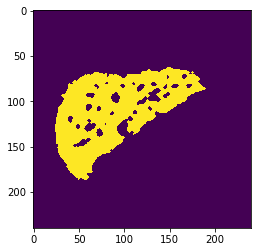

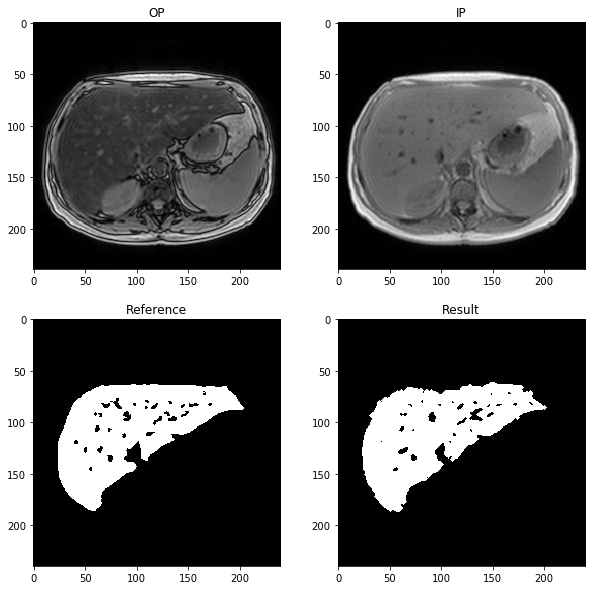

10
10
10
10
10
10


In [561]:
# S01-49

inputOP = np.genfromtxt("dataset01\s01-49-op-228.txt")
inputIP = np.genfromtxt("dataset01\s01-49-ip-447.txt")
inputref = np.genfromtxt("dataset01\s01-49-ref.txt")

result_s01_49, dice_f49, jacc_f49, accu_f49, sens_f49, spec_f49, tempo_f49 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_49_10.bmp', result_s01_49)

listaDICE_S01_49.append(dice_f49)
listaJACC_S01_49.append(jacc_f49)
listaACCU_S01_49.append(accu_f49)
listaSENS_S01_49.append(sens_f49)
listaSPEC_S01_49.append(spec_f49)
listaTEMPO_S01_49.append(tempo_f49)

print(len(listaDICE_S01_49))
print(len(listaJACC_S01_49))
print(len(listaACCU_S01_49))
print(len(listaSENS_S01_49))
print(len(listaSPEC_S01_49))
print(len(listaTEMPO_S01_49))

del(inputOP)
del(inputIP)
del(inputref)

In [554]:
listaDICE_S01_51 = []
listaJACC_S01_51 = []
listaACCU_S01_51 = []
listaSENS_S01_51 = []
listaSPEC_S01_51 = []
listaTEMPO_S01_51 = []

[(73, 153), (52, 146), (34, 155), (33, 140), (33, 127), (37, 108), (46, 93), (58, 82), (75, 76), (90, 76), (114, 75), (136, 74), (160, 74), (192, 80), (142, 107), (116, 119), (88, 148), (78, 150)]
(192, 80)


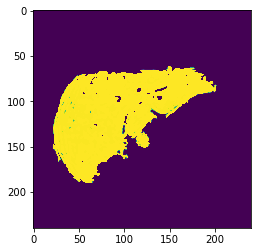

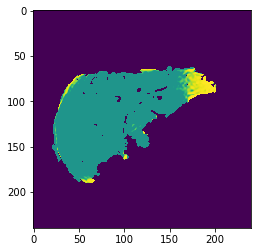

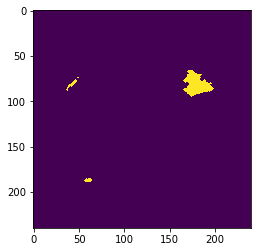

(33, 140)


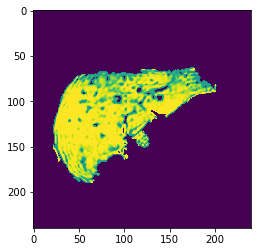

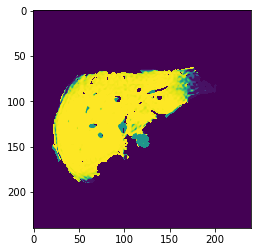

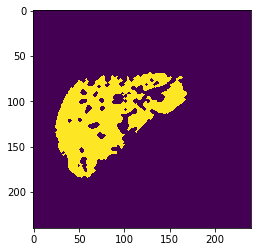

(88, 148)


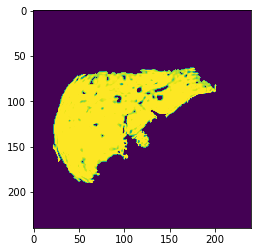

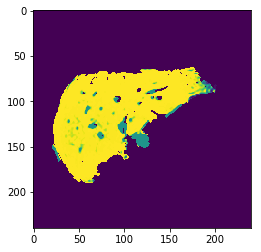

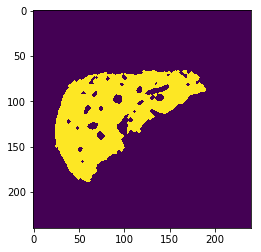

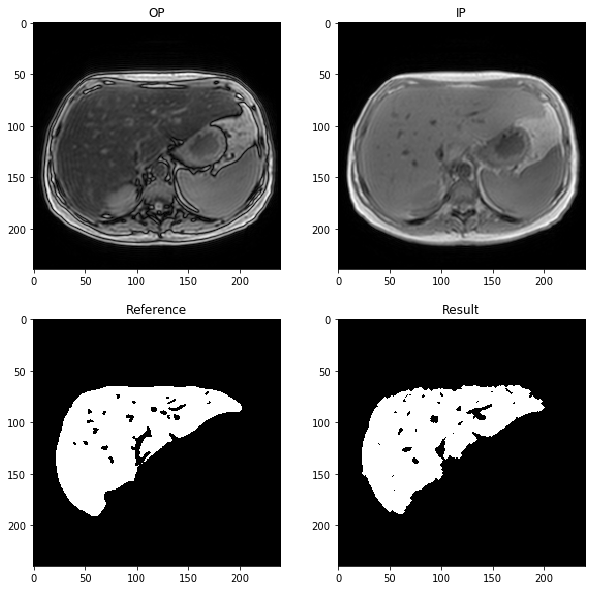

10
10
10
10
10
10


In [577]:
# S01-51

inputOP = np.genfromtxt("dataset01\s01-51-op-228.txt")
inputIP = np.genfromtxt("dataset01\s01-51-ip-447.txt")
inputref = np.genfromtxt("dataset01\s01-51-ref.txt")

result_s01_51, dice_f51, jacc_f51, accu_f51, sens_f51, spec_f51, tempo_f51 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_51_10.bmp', result_s01_51)

listaDICE_S01_51.append(dice_f51)
listaJACC_S01_51.append(jacc_f51)
listaACCU_S01_51.append(accu_f51)
listaSENS_S01_51.append(sens_f51)
listaSPEC_S01_51.append(spec_f51)
listaTEMPO_S01_51.append(tempo_f51)

print(len(listaDICE_S01_51))
print(len(listaJACC_S01_51))
print(len(listaACCU_S01_51))
print(len(listaSENS_S01_51))
print(len(listaSPEC_S01_51))
print(len(listaTEMPO_S01_51))

del(inputOP)
del(inputIP)
del(inputref)

In [563]:
listaDICE_S01_53 = []
listaJACC_S01_53 = []
listaACCU_S01_53 = []
listaSENS_S01_53 = []
listaSPEC_S01_53 = []
listaTEMPO_S01_53 = []

[(147, 110), (161, 99), (184, 91), (167, 76), (124, 79), (88, 75), (63, 72), (50, 90), (41, 107), (37, 134), (39, 157), (52, 172), (74, 175), (87, 164), (84, 130), (53, 133), (73, 116), (84, 88)]
(63, 72)


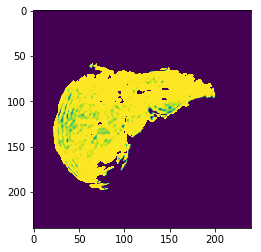

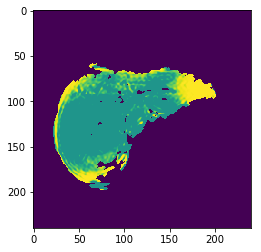

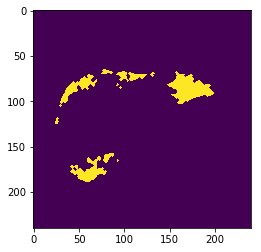

(147, 110)


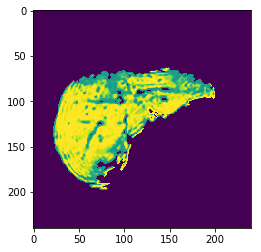

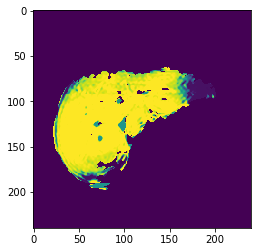

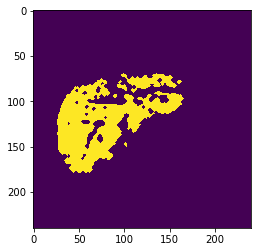

(39, 157)


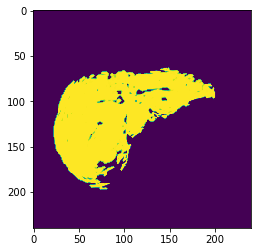

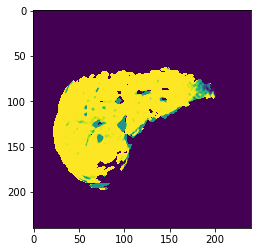

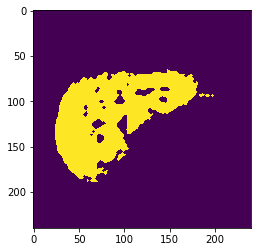

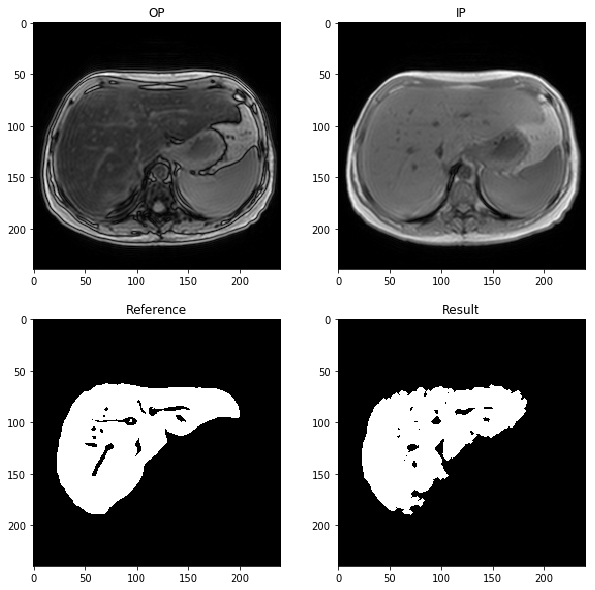

10
10
10
10
10
10


In [614]:
# S01-53

inputOP = np.genfromtxt("dataset01\s01-53-op-238.txt")
inputIP = np.genfromtxt("dataset01\s01-53-ip-452.txt")
inputref = np.genfromtxt("dataset01\s01-53-ref.txt")

result_s01_53, dice_f53, jacc_f53, accu_f53, sens_f53, spec_f53, tempo_f53 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_53_10.bmp', result_s01_53)

listaDICE_S01_53.append(dice_f53)
listaJACC_S01_53.append(jacc_f53)
listaACCU_S01_53.append(accu_f53)
listaSENS_S01_53.append(sens_f53)
listaSPEC_S01_53.append(spec_f53)
listaTEMPO_S01_53.append(tempo_f53)

print(len(listaDICE_S01_53))
print(len(listaJACC_S01_53))
print(len(listaACCU_S01_53))
print(len(listaSENS_S01_53))
print(len(listaSPEC_S01_53))
print(len(listaTEMPO_S01_53))

del(inputOP)
del(inputIP)
del(inputref)

In [616]:
listaDICE_S01_55 = []
listaJACC_S01_55 = []
listaACCU_S01_55 = []
listaSENS_S01_55 = []
listaSPEC_S01_55 = []
listaTEMPO_S01_55 = []

[(65, 185), (40, 171), (36, 146), (39, 108), (50, 84), (88, 78), (140, 80), (180, 82), (133, 108), (111, 119), (68, 133)]
(180, 82)


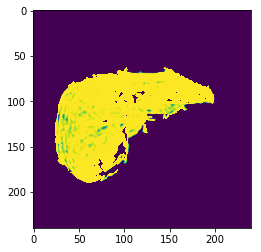

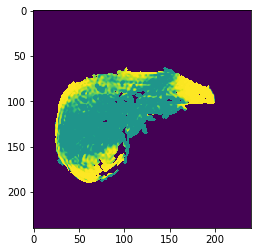

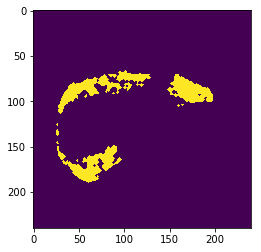

(36, 146)


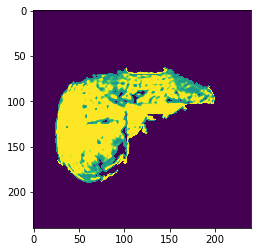

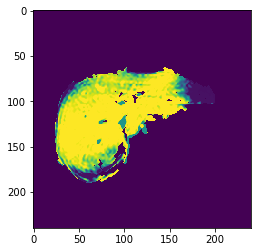

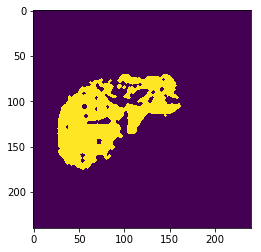

(65, 185)


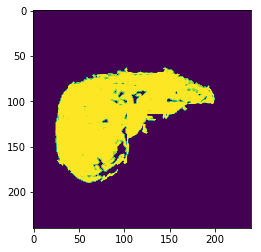

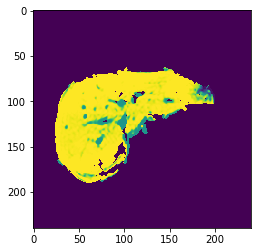

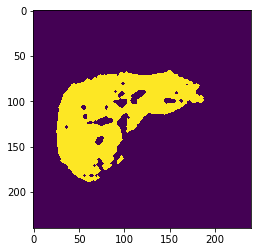

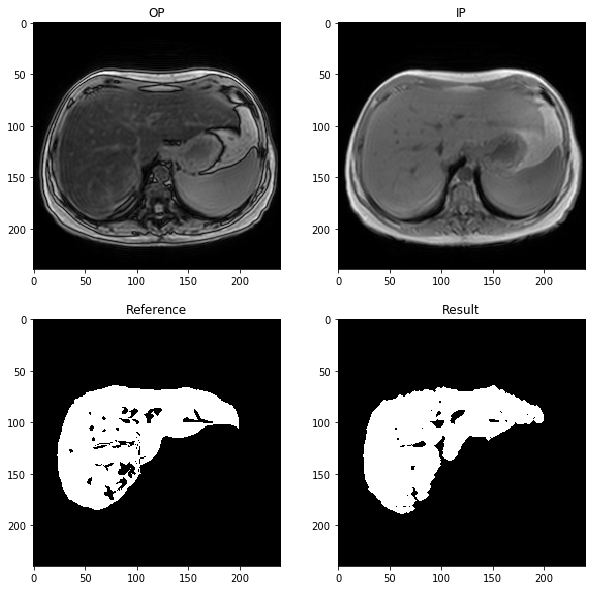

10
10
10
10
10
10


In [633]:
# S01-55

inputOP = np.genfromtxt("dataset01\s01-55-op-243.txt")
inputIP = np.genfromtxt("dataset01\s01-55-ip-459.txt")
inputref = np.genfromtxt("dataset01\s01-55-ref.txt")

result_s01_55, dice_f55, jacc_f55, accu_f55, sens_f55, spec_f55, tempo_f55 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s01_55_10.bmp', result_s01_55)

listaDICE_S01_55.append(dice_f55)
listaJACC_S01_55.append(jacc_f55)
listaACCU_S01_55.append(accu_f55)
listaSENS_S01_55.append(sens_f55)
listaSPEC_S01_55.append(spec_f55)
listaTEMPO_S01_55.append(tempo_f55)

print(len(listaDICE_S01_55))
print(len(listaJACC_S01_55))
print(len(listaACCU_S01_55))
print(len(listaSENS_S01_55))
print(len(listaSPEC_S01_55))
print(len(listaTEMPO_S01_55))

del(inputOP)
del(inputIP)
del(inputref)

In [639]:
print('MEDIA DE CADA CORTE')

print(np.mean(listaDICE_S01_03))

print(np.mean(listaJACC_S01_03))

print(np.mean(listaACCU_S01_03))

print(np.mean(listaSENS_S01_03))

print(np.mean(listaSPEC_S01_03))

print(np.mean(listaTEMPO_S01_03))

MEDIA DE CADA CORTE
0.931845889164
0.872398989611
0.997802083333
0.911052631579
0.999256840247
20.363800025


In [640]:
########################################

print np.mean(listaDICE_S01_05)

print np.mean(listaJACC_S01_05)

print np.mean(listaACCU_S01_05)

print np.mean(listaSENS_S01_05)

print np.mean(listaSPEC_S01_05)

print np.mean(listaTEMPO_S01_05)

0.950385488345
0.905475822748
0.997189236111
0.94804400978
0.998625902366
26.8637999535


In [641]:
print np.mean(listaDICE_S01_07)

print np.mean(listaJACC_S01_07)

print np.mean(listaACCU_S01_07)

print np.mean(listaSENS_S01_07)

print np.mean(listaSPEC_S01_07)

print np.mean(listaTEMPO_S01_07)

0.941102886813
0.888785438539
0.994848958333
0.942743538767
0.997227920487
34.3504999638


In [642]:
print np.mean(listaDICE_S01_09)

print np.mean(listaJACC_S01_09)

print np.mean(listaACCU_S01_09)

print np.mean(listaSENS_S01_09)

print np.mean(listaSPEC_S01_09)

print np.mean(listaTEMPO_S01_09)

0.922171089088
0.855646344708
0.991611111111
0.929192345118
0.995140965204
34.7285000324


In [643]:
########################################

print np.mean(listaDICE_S01_11)

print np.mean(listaJACC_S01_11)

print np.mean(listaACCU_S01_11)

print np.mean(listaSENS_S01_11)

print np.mean(listaSPEC_S01_11)

print np.mean(listaTEMPO_S01_11)

0.935272769572
0.87877130626
0.99203125
0.945939806928
0.995033100337
42.4703000069


In [644]:
########################################

print np.mean(listaDICE_S01_13)

print np.mean(listaJACC_S01_13)

print np.mean(listaACCU_S01_13)

print np.mean(listaSENS_S01_13)

print np.mean(listaSPEC_S01_13)

print np.mean(listaTEMPO_S01_13)

0.934050785878
0.876322147979
0.990236111111
0.934161199625
0.99472361809
0.0305000305176


In [645]:
########################################

print np.mean(listaDICE_S01_15)

print np.mean(listaJACC_S01_15)

print np.mean(listaACCU_S01_15)

print np.mean(listaSENS_S01_15)

print np.mean(listaSPEC_S01_15)

print np.mean(listaTEMPO_S01_15)

0.939928403549
0.886672336287
0.989782986111
0.958010819809
0.992675304012
38.137100029


In [646]:
########################################

print np.mean(listaDICE_S01_17)

print np.mean(listaJACC_S01_17)

print np.mean(listaACCU_S01_17)

print np.mean(listaSENS_S01_17)

print np.mean(listaSPEC_S01_17)

print np.mean(listaTEMPO_S01_17)

0.93301845479
0.874458501527
0.987574652778
0.95363427697
0.990962728175
43.4718999147


In [647]:
########################################

print np.mean(listaDICE_S01_19)

print np.mean(listaJACC_S01_19)

print np.mean(listaACCU_S01_19)

print np.mean(listaSENS_S01_19)

print np.mean(listaSPEC_S01_19)

print np.mean(listaTEMPO_S01_19)

0.932657085182
0.87383337098
0.986223958333
0.942080905039
0.991198856392
39.7465999842


In [648]:
########################################

print np.mean(listaDICE_S01_21)

print np.mean(listaJACC_S01_21)

print np.mean(listaACCU_S01_21)

print np.mean(listaSENS_S01_21)

print np.mean(listaSPEC_S01_21)

print np.mean(listaTEMPO_S01_21)

0.926959260088
0.863885173347
0.984461805556
0.956719434153
0.987650497464
44.5544000149


In [649]:
########################################

print np.mean(listaDICE_S01_23)

print np.mean(listaJACC_S01_23)

print np.mean(listaACCU_S01_23)

print np.mean(listaSENS_S01_23)

print np.mean(listaSPEC_S01_23)

print np.mean(listaTEMPO_S01_23)

0.938807270879
0.88472068222
0.986456597222
0.931922178988
0.993303370787
46.0374000311


In [650]:
########################################

print np.mean(listaDICE_S01_25)

print np.mean(listaJACC_S01_25)

print np.mean(listaACCU_S01_25)

print np.mean(listaSENS_S01_25)

print np.mean(listaSPEC_S01_25)

print np.mean(listaTEMPO_S01_25)

0.921819193442
0.85516579351
0.982279513889
0.923161764706
0.98983591792
62.4258999825


In [651]:
########################################

print np.mean(listaDICE_S01_27)

print np.mean(listaJACC_S01_27)

print np.mean(listaACCU_S01_27)

print np.mean(listaSENS_S01_27)

print np.mean(listaSPEC_S01_27)

print np.mean(listaTEMPO_S01_27)

0.934060691179
0.876411744803
0.983840277778
0.937095859331
0.990361636464
55.5957000256


In [652]:
########################################

print np.mean(listaDICE_S01_29)

print np.mean(listaJACC_S01_29)

print np.mean(listaACCU_S01_29)

print np.mean(listaSENS_S01_29)

print np.mean(listaSPEC_S01_29)

print np.mean(listaTEMPO_S01_29)

0.935221382135
0.87841609754
0.983680555556
0.935329753545
0.990656972009
58.0125999928


In [653]:
########################################

print np.mean(listaDICE_S01_31)

print np.mean(listaJACC_S01_31)

print np.mean(listaACCU_S01_31)

print np.mean(listaSENS_S01_31)

print np.mean(listaSPEC_S01_31)

print np.mean(listaTEMPO_S01_31)

0.934663449495
0.877348766752
0.982550347222
0.923070997561
0.991851197527
55.2132999659


In [654]:
########################################

print np.mean(listaDICE_S01_33)

print np.mean(listaJACC_S01_33)

print np.mean(listaACCU_S01_33)

print np.mean(listaSENS_S01_33)

print np.mean(listaSPEC_S01_33)

print np.mean(listaTEMPO_S01_33)

0.92941639033
0.868221274595
0.980079861111
0.951844391288
0.984596330829
0.0314999818802


In [655]:
########################################

print np.mean(listaDICE_S01_35)

print np.mean(listaJACC_S01_35)

print np.mean(listaACCU_S01_35)

print np.mean(listaSENS_S01_35)

print np.mean(listaSPEC_S01_35)

print np.mean(listaTEMPO_S01_35)

0.926010541883
0.862356882117
0.97878279321
0.938315539739
0.985451367122
65.8236666785


In [657]:
########################################

print np.mean(listaDICE_S01_39)

print np.mean(listaJACC_S01_39)

print np.mean(listaACCU_S01_39)

print np.mean(listaSENS_S01_39)

print np.mean(listaSPEC_S01_39)

print np.mean(listaTEMPO_S01_39)

0.905154947126
0.826752859914
0.970930555556
0.914827112434
0.980958130397
68.497200036


In [658]:
########################################

print np.mean(listaDICE_S01_41)

print np.mean(listaJACC_S01_41)

print np.mean(listaACCU_S01_41)

print np.mean(listaSENS_S01_41)

print np.mean(listaSPEC_S01_41)

print np.mean(listaTEMPO_S01_41)

0.914202114678
0.84203539384
0.971831597222
0.894734119594
0.987378478742
71.1652000189


In [659]:
########################################

print np.mean(listaDICE_S01_43)

print np.mean(listaJACC_S01_43)

print np.mean(listaACCU_S01_43)

print np.mean(listaSENS_S01_43)

print np.mean(listaSPEC_S01_43)

print np.mean(listaTEMPO_S01_43)

0.932391187198
0.873518521594
0.975666666667
0.898385300668
0.993452075859
70.8752999783


In [660]:
########################################

print np.mean(listaDICE_S01_45)

print np.mean(listaJACC_S01_45)

print np.mean(listaACCU_S01_45)

print np.mean(listaSENS_S01_45)

print np.mean(listaSPEC_S01_45)

print np.mean(listaTEMPO_S01_45)

0.939632674649
0.886372736942
0.978309027778
0.929638806824
0.98915023245
72.8158000469


In [661]:
########################################

print np.mean(listaDICE_S01_47)

print np.mean(listaJACC_S01_47)

print np.mean(listaACCU_S01_47)

print np.mean(listaSENS_S01_47)

print np.mean(listaSPEC_S01_47)

print np.mean(listaTEMPO_S01_47)

0.942449151742
0.891196773082
0.978442708333
0.92018273928
0.99227860611
72.3296000481


In [662]:
########################################

print np.mean(listaDICE_S01_49)

print np.mean(listaJACC_S01_49)

print np.mean(listaACCU_S01_49)

print np.mean(listaSENS_S01_49)

print np.mean(listaSPEC_S01_49)

print np.mean(listaTEMPO_S01_49)

0.939377229023
0.885689573917
0.977243055556
0.942258094443
0.985297195703
70.0582000017


In [663]:
########################################

print np.mean(listaDICE_S01_51)

print np.mean(listaJACC_S01_51)

print np.mean(listaACCU_S01_51)

print np.mean(listaSENS_S01_51)

print np.mean(listaSPEC_S01_51)

print np.mean(listaTEMPO_S01_51)

0.942178119689
0.890728894582
0.977753472222
0.928850768821
0.989624371615
74.256799984


In [664]:
########################################

print np.mean(listaDICE_S01_53)

print np.mean(listaJACC_S01_53)

print np.mean(listaACCU_S01_53)

print np.mean(listaSENS_S01_53)

print np.mean(listaSPEC_S01_53)

print np.mean(listaTEMPO_S01_53)

0.919305768244
0.850704588998
0.967786458333
0.893484323502
0.986997181375
81.7378999949


In [665]:
########################################

print np.mean(listaDICE_S01_55)

print np.mean(listaJACC_S01_55)

print np.mean(listaACCU_S01_55)

print np.mean(listaSENS_S01_55)

print np.mean(listaSPEC_S01_55)

print np.mean(listaTEMPO_S01_55)

0.909927097901
0.834813078141
0.966197916667
0.892438803264
0.983667597166
72.5464999676


In [681]:
DICET = listaDICE_S01_03 + listaDICE_S01_05 + listaDICE_S01_07 + listaDICE_S01_09 + listaDICE_S01_11 + listaDICE_S01_13 + listaDICE_S01_15 + listaDICE_S01_17 + listaDICE_S01_19 + listaDICE_S01_21 + listaDICE_S01_23 + listaDICE_S01_25 + listaDICE_S01_27 + listaDICE_S01_29 + listaDICE_S01_31 + listaDICE_S01_33 + listaDICE_S01_35 + listaDICE_S01_39 + listaDICE_S01_41 + listaDICE_S01_43 + listaDICE_S01_45 + listaDICE_S01_47 + listaDICE_S01_49 + listaDICE_S01_51 + listaDICE_S01_53 + listaDICE_S01_55

In [682]:
JACCT = listaJACC_S01_03 + listaJACC_S01_05 + listaJACC_S01_07 + listaJACC_S01_09 + listaJACC_S01_11 + listaJACC_S01_13 + listaJACC_S01_15 + listaJACC_S01_17 + listaJACC_S01_19 + listaJACC_S01_21 + listaJACC_S01_23 + listaJACC_S01_25 + listaJACC_S01_27 + listaJACC_S01_29 + listaJACC_S01_31 + listaJACC_S01_33 + listaJACC_S01_35 + listaJACC_S01_39 + listaJACC_S01_41 + listaJACC_S01_43 + listaJACC_S01_45 + listaJACC_S01_47 + listaJACC_S01_49 + listaJACC_S01_51 + listaJACC_S01_53 + listaJACC_S01_55

In [683]:
ACCUT = listaACCU_S01_03 + listaACCU_S01_05 + listaACCU_S01_07 + listaACCU_S01_09 + listaACCU_S01_11 + listaACCU_S01_13 + listaACCU_S01_15 + listaACCU_S01_17 + listaACCU_S01_19 + listaACCU_S01_21 + listaACCU_S01_23 + listaACCU_S01_25 + listaACCU_S01_27 + listaACCU_S01_29 + listaACCU_S01_31 + listaACCU_S01_33 + listaACCU_S01_35 + listaACCU_S01_39 + listaACCU_S01_41 + listaACCU_S01_43 + listaACCU_S01_45 + listaACCU_S01_47 + listaACCU_S01_49 + listaACCU_S01_51 + listaACCU_S01_53 + listaACCU_S01_55

In [684]:
SENST = listaSENS_S01_03 + listaSENS_S01_05 + listaSENS_S01_07 + listaSENS_S01_09 + listaSENS_S01_11 + listaSENS_S01_13 + listaSENS_S01_15 + listaSENS_S01_17 + listaSENS_S01_19 + listaSENS_S01_21 + listaSENS_S01_23 + listaSENS_S01_25 + listaSENS_S01_27 + listaSENS_S01_29 + listaSENS_S01_31 + listaSENS_S01_33 + listaSENS_S01_35 + listaSENS_S01_39 + listaSENS_S01_41 + listaSENS_S01_43  + listaSENS_S01_45 + listaSENS_S01_47 + listaSENS_S01_49 + listaSENS_S01_51 + listaSENS_S01_53 + listaSENS_S01_55

In [688]:
SPECT = listaSPEC_S01_03 + listaSPEC_S01_05 + listaSPEC_S01_07 + listaSPEC_S01_09 + listaSPEC_S01_11 + listaSPEC_S01_13 + listaSPEC_S01_15 + listaSPEC_S01_17 + listaSPEC_S01_19 + listaSPEC_S01_21 + listaSPEC_S01_23 + listaSPEC_S01_25 + listaSPEC_S01_27 + listaSPEC_S01_29 + listaSPEC_S01_31 + listaSPEC_S01_33 + listaSPEC_S01_35 + listaSPEC_S01_39 + listaSPEC_S01_41 + listaSPEC_S01_43 + listaSPEC_S01_45 + listaSPEC_S01_47 + listaSPEC_S01_49 + listaSPEC_S01_51 + listaSPEC_S01_53 + listaSPEC_S01_55

In [2]:
TEMPOT = listaTEMPO_S01_03 + listaTEMPO_S01_05 + listaTEMPO_S01_07 + listaTEMPO_S01_09 + listaTEMPO_S01_11 + listaTEMPO_S01_13 + listaTEMPO_S01_15 + listaTEMPO_S01_17 + listaTEMPO_S01_19 + listaTEMPO_S01_21 + listaTEMPO_S01_23 + listaTEMPO_S01_25 + listaTEMPO_S01_27 + listaTEMPO_S01_29 + listaTEMPO_S01_31 + listaTEMPO_S01_33 + listaTEMPO_S01_35 + listaTEMPO_S01_39 + listaTEMPO_S01_41 + listaTEMPO_S01_43 + listaTEMPO_S01_45 + listaTEMPO_S01_47 + listaTEMPO_S01_49 + listaTEMPO_S01_51 + listaTEMPO_S01_53 + listaTEMPO_S01_55

NameError: name 'listaTEMPO_S01_03' is not defined

In [1]:
print TEMPOT

NameError: name 'TEMPOT' is not defined

In [692]:
print('MEDIA E DESVIO TOTAL')
print('\n')
print(np.mean(DICET))
print(np.std(DICET))
print('\n')
print(np.mean(JACCT))
print(np.std(JACCT))
print('\n')
print(np.mean(ACCUT))
print(np.std(ACCUT))
print('\n')
print(np.mean(SENST))
print(np.std(SENST))
print('\n')
print(np.mean(SPECT))
print(np.std(SPECT))
print('\n')
print(np.mean(TEMPOT))
print(np.std(TEMPOT))

MEDIA E DESVIO TOTAL


0.931251284474
0.0124967854618


0.871601058159
0.0217063204568


0.982846149721
0.00857206502607


0.929856678293
0.0243663067509


0.990687693364
0.00461695221075


50.7937297306
23.225662291
